# Lookahead-study | Liver model (M2)

In [1]:
import pyabc
import cProfile
import numpy as np
import scipy.stats as st
import tempfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import time
from pyabc import History
import logging
import matplotlib.patches as mpatches
import math
from pathlib import Path
import matplotlib as mpl
from numpy import genfromtxt
import pickle
import copy
from pyabc.weighted_statistics import weighted_quantile

samplers_color =["#8AA8A1", "#885A89", "#CBCBD4"]
samplers_color_double =["#8AA8A1", "#885A89", "#CBCBD4", "#8AA8A1", "#885A89", "#CBCBD4"]
sampler_labels = ["DYN", "LA Pre", "LA Cur"]
colors_map = {'LA':samplers_color[2], 'DYN':samplers_color[0], 'LA_pre':samplers_color[1]}         
colors = [samplers_color[0], samplers_color[0], samplers_color[1],
          samplers_color[1], samplers_color[2] , samplers_color[2]]
colors_map_eps = {'liver_500_256':samplers_color[2], 'liver_1000_256':samplers_color[2],
              'liver_500_256_ORI':samplers_color[0], 'liver_1000_256_ORI':samplers_color[0],
             'liver_500_256_la_pre':samplers_color[1], 'liver_1000_256_la_pre':samplers_color[1],
                 'liver_250_128':samplers_color[2], 'liver_500_128':samplers_color[2],
              'liver_250_128_ORI':samplers_color[0], 'liver_500_128_ORI':samplers_color[0],
             'liver_250_128_la_pre':samplers_color[1], 'liver_500_128_la_pre':samplers_color[1]}         


## Configration 1, simulation time maximum limit=900

In [2]:
gp = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + "/Data/Model_M2/900_db"
samplers_color =["#8AA8A1", "#885A89", "#CBCBD4"]
sampler_labels = ["DYN", "LA Pre", "LA Cur"]


# 256 cores on population size of = 1000 and 500 (Eps <1.4e+03)

{'liver_1000_256': [100408.717086, 123128.354867], 'liver_1000_256_ORI': [136499.917921, 152962.539838], 'liver_1000_256_la_pre': [134159.624003, 134107.963252], 'liver_500_256': [100797.360003, 43881.533581], 'liver_500_256_ORI': [14616.945188, 35225.905672], 'liver_500_256_la_pre': [44753.529616, 46444.396946]}


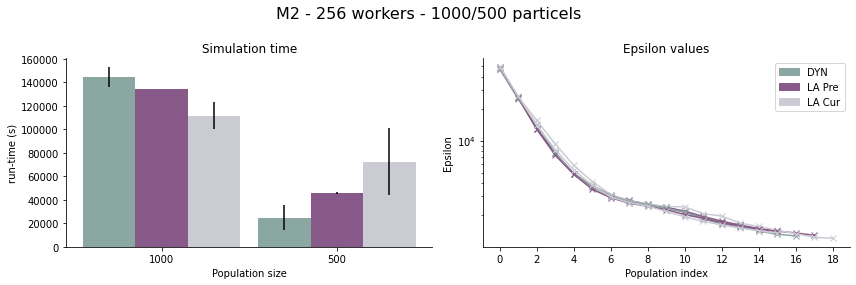

In [3]:
import pyabc
import matplotlib.pyplot as plt
import numpy as np

pyabc.settings.set_figure_params("pyabc")

sampler_labels = ["liver_1000_256", "liver_1000_256_ORI", "liver_1000_256_la_pre",
                  "liver_500_256", "liver_500_256_ORI", "liver_500_256_la_pre"]

sampler = "data_la"
model_id = "TumorRes"

pop_size = 1000
worker_size = 256
sigma = 0.5
iters = 2


population_index = {"liver_1000_256_1": 15, "liver_1000_256_2": 16,
                    "liver_1000_256_ORI_1": 17, "liver_1000_256_ORI_2": 16, "liver_1000_256_ORI_1_confirmation": 16,
                    "liver_1000_256_la_pre_1": 16,"liver_1000_256_la_pre_2": 16,
                   "liver_500_256_1": 15, "liver_500_256_2": 14, 
                    "liver_500_256_ORI_1": 11, "liver_500_256_ORI_2": 15, "liver_500_256_ORI_1_confirmation": 16, "liver_500_256_ORI_2_confirmation": 12, 
                    "liver_500_256_la_pre_1": 15,"liver_500_256_la_pre_2": 17,
}
times = []
samples = []
time_new = {}
sample_new = {}
for sampler_label in sampler_labels:
    times_for_sampler = []
    samples_for_sampler = []
    for ix in range(iters):
        if f"{sampler_label}_{str(ix+1)}" in ["liver_1000_256_ORI_1", "liver_500_256_ORI_1", "liver_500_256_ORI_2"]:
            sampler_db = f"{sampler_label}_{str(ix+1)}_confirmation"
        else:
            sampler_db = f"{sampler_label}_{str(ix+1)}"
        h = pyabc.History(
            f"sqlite:///{gp}/{sampler_db}.db", create=False)
        abc = h.get_abc()
        if abc.end_time is None:
            times_for_sampler.append(
                (h.get_all_populations()["population_end_time"][population_index[sampler_db]] - abc.start_time).total_seconds())
        else:
            times_for_sampler.append(
                (abc.end_time - abc.start_time).total_seconds())
        samples_for_sampler.append(list(h.get_all_populations()["samples"]))
    time_new[sampler_label] = times_for_sampler
    sample_new[sampler_label] = samples_for_sampler

#     samples.append(samples_for_sampler)
#     times.append(times_for_sampler)
# print("time=", times)

# times = np.array(times)
# times /= np.max(np.mean(times, axis=1))
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
print(time_new)


x = np.arange(2)
f_width = 0.3
axes[0].bar(
    x-0.3,
    height=[np.mean(time_new["liver_1000_256_ORI"]), np.mean(time_new["liver_500_256_ORI"])],
    width = f_width,
    yerr=[np.std(time_new["liver_1000_256_ORI"]), np.std(time_new["liver_500_256_ORI"])],
    color=colors_map["DYN"]
)

axes[0].bar(
    x,
    height=[np.mean(time_new["liver_1000_256_la_pre"]), np.mean(time_new["liver_500_256_la_pre"])],
    width = f_width,
    yerr=[np.std(time_new["liver_1000_256_la_pre"]), np.std(time_new["liver_500_256_la_pre"])],
    color=colors_map["LA_pre"]

)
axes[0].bar(
    x+0.3,
    height=[np.mean(time_new["liver_1000_256"]), np.mean(time_new["liver_500_256"])],
    width = f_width,
    yerr=[np.std(time_new["liver_1000_256"]), np.std(time_new["liver_500_256"])],
    color=colors_map["LA"]
)

axes[0].set_xticks(x, ['1000', '500'])
axes[0].set_xlabel("Population size")
axes[0].set_ylabel("run-time (s)")
# axes[0].legend(["LA", "DYN", "LA_pre"])
axes[0].set_title("Simulation time")




# axes[0].bar(
#     x=np.arange(4),
#     height=np.mean(time_new[]),
#     yerr=np.std(times, axis=1),
#     color=colors,label=["1", "2", "3", "4"]
# )

# labels = list(colors_map.keys())
# handles = [plt.Rectangle((0,0),1,1, color=colors_map[label]) for label in labels]
# axes[0].legend(handles, labels)


db_list = []
for sampler_ix, sampler_label in enumerate(sampler_labels):
    for ix in range(iters):
        h = pyabc.History(
            f"sqlite:///{gp}/{sampler_label}_{str(ix+1)}.db", create=False)
        db_list.append(h)
pyabc.visualization.plot_epsilons(db_list, ax=axes[1], colors=samplers_color_double)
labels = list(colors_map.keys())

DYN_patch = mpatches.Patch(color=samplers_color[0], label='DYN')
Pre_patch = mpatches.Patch(color=samplers_color[1], label='LA Pre')
Curr_patch = mpatches.Patch(color=samplers_color[2], label='LA Cur')
axes[1].legend(handles=[DYN_patch, Pre_patch, Curr_patch])

# axes[1].legend()
fig.suptitle(f"M2 - {worker_size} workers - 1000/500 particels", fontsize=16)
fig.tight_layout()

fig.subplots_adjust(top=0.80)
plt.savefig(f"M2_figures/M2_time_epsilon_1000_500px{worker_size}w.pdf", format="pdf", bbox_inches="tight")


In [4]:
LA_pre_mean_256 = []
LA_curr_mean_256 = []
DYN_mean_256 = []
LA_pre_mean_256 = time_new["liver_500_256_la_pre"] + time_new["liver_1000_256_la_pre"]
LA_curr_mean_256 = time_new["liver_500_256"] + time_new["liver_1000_256"]
DYN_mean_256 = time_new["liver_500_256_ORI"] + time_new["liver_1000_256_ORI"]

LA_pre_median_256 = []
LA_curr_median_256 = []
DYN_median_256 = []
LA_pre_median_256 = time_new["liver_500_256_la_pre"] + time_new["liver_1000_256_la_pre"]
LA_curr_median_256 = time_new["liver_500_256"] + time_new["liver_1000_256"]
DYN_median_256 = time_new["liver_500_256_ORI"] + time_new["liver_1000_256_ORI"]


<BarContainer object of 3 artists>

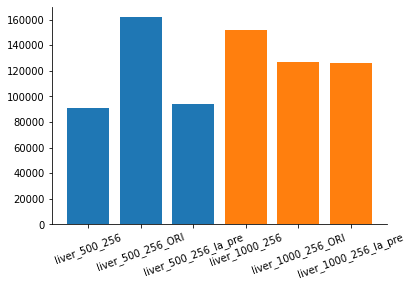

In [5]:
sample_new["liver_500_256_la_pre"][0]
sample_sizes = {}
for key, val in sample_new.items():
    sample_sizes[key]=min(map(len, val))
sample_sizes
total_samples = {}
for key, val in sample_new.items():
    single_list = []
    single_list = [x + y for x, y in zip(val[0], val[1])]

    if key in sample_new:
        total_samples[key] = sum(single_list)
    else:
        total_samples[key] += sum(single_list)
ave_sample_per_h = {}
for key, val in sample_sizes.items():
    ave_sample_per_h[key] = total_samples[key]/val

plt.xticks(rotation=20)
d1000 = dict(list(ave_sample_per_h.items())[len(ave_sample_per_h)//2:])
d500 = dict(list(ave_sample_per_h.items())[:len(ave_sample_per_h)//2])

plt.bar(list(d1000.keys()), list(d1000.values()))
plt.bar(list(d500.keys()), list(d500.values()))


## 128 cores on population size of = 500 and 250 (Eps <2.0e+03)

{'liver_500_128': [39629.995164, 37052.091876], 'liver_500_128_ORI': [61820.563403, 39008.402678], 'liver_500_128_la_pre': [17196.392269, 24511.418934], 'liver_250_128': [16751.663488, 24816.361327], 'liver_250_128_ORI': [23399.828784, 24716.378284], 'liver_250_128_la_pre': [6542.962679, 31920.090779]}


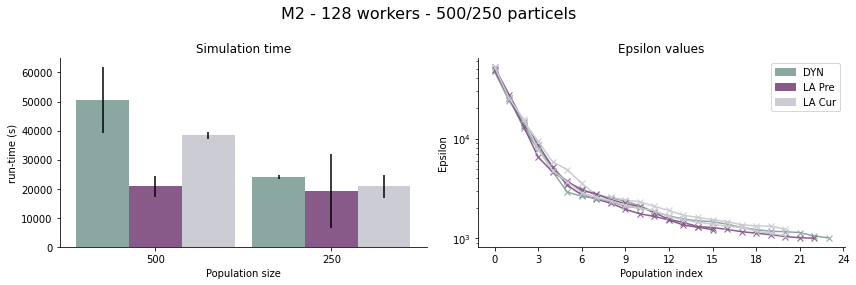

In [6]:
import pyabc
import matplotlib.pyplot as plt
import numpy as np

pyabc.settings.set_figure_params("pyabc")

sampler_labels = ["liver_500_128", "liver_500_128_ORI", "liver_500_128_la_pre",
                  "liver_250_128", "liver_250_128_ORI", "liver_250_128_la_pre"]

sampler = "data_la"
model_id = "TumorRes"

pop_size = 1000
worker_size = 128
sigma = 0.5
iters = 2


population_index = {"liver_500_128_1": 12, "liver_500_128_2": 10,
                    "liver_500_128_ORI_1": 13, "liver_500_128_ORI_2": 11,
                    "liver_500_128_la_pre_1": 12,"liver_500_128_la_pre_2": 12,
                   "liver_250_128_1": 10, "liver_250_128_2": 9, 
                    "liver_250_128_ORI_1": 11, "liver_250_128_ORI_2": 7,
                    "liver_250_128_la_pre_1": 13,"liver_250_128_la_pre_2": 15,
}
times = []
samples = []
time_new = {}
sample_new = {}
for sampler_label in sampler_labels:
    times_for_sampler = []
    samples_for_sampler = []
    for ix in range(iters):
        sampler_db = f"{sampler_label}_{str(ix+1)}"
        h = pyabc.History(
            f"sqlite:///{gp}/{sampler_db}.db", create=False)
        abc = h.get_abc()
        if abc.end_time is None:
            times_for_sampler.append(
                (h.get_all_populations()["population_end_time"][population_index[sampler_db]] - abc.start_time).total_seconds())
        else:
            times_for_sampler.append(
                (abc.end_time - abc.start_time).total_seconds())
        samples_for_sampler.append(list(h.get_all_populations()["samples"]))
    time_new[sampler_label] = times_for_sampler
    sample_new[sampler_label] = samples_for_sampler

#     samples.append(samples_for_sampler)
#     times.append(times_for_sampler)
# print("time=", times)

# times = np.array(times)
# times /= np.max(np.mean(times, axis=1))
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
print(time_new)


x = np.arange(2)
f_width = 0.3

axes[0].bar(
    x-0.3,
    height=[np.mean(time_new["liver_500_128_ORI"]), np.mean(time_new["liver_250_128_ORI"])],
    width = f_width,
    yerr=[np.std(time_new["liver_500_128_ORI"]), np.std(time_new["liver_250_128_ORI"])],
    color=colors_map["DYN"]
)


axes[0].bar(
    x,
    height=[np.mean(time_new["liver_500_128_la_pre"]), np.mean(time_new["liver_250_128_la_pre"])],
    width = f_width,
    yerr=[np.std(time_new["liver_500_128_la_pre"]), np.std(time_new["liver_250_128_la_pre"])],
    color=colors_map["LA_pre"]

)

axes[0].bar(
    x+0.3,
    height=[np.mean(time_new["liver_500_128"]), np.mean(time_new["liver_250_128"])],
    width = f_width,
    yerr=[np.std(time_new["liver_500_128"]), np.std(time_new["liver_250_128"])],
    color=colors_map["LA"]
)

axes[0].set_xticks(x, ['500', '250'])
axes[0].set_xlabel("Population size")
axes[0].set_ylabel("run-time (s)")
# axes[0].legend(["LA", "DYN", "LA_pre"])
axes[0].set_title("Simulation time")




# axes[0].bar(
#     x=np.arange(4),
#     height=np.mean(time_new[]),
#     yerr=np.std(times, axis=1),
#     color=colors,label=["1", "2", "3", "4"]
# )

# labels = list(colors_map.keys())
# handles = [plt.Rectangle((0,0),1,1, color=colors_map[label]) for label in labels]
# axes[0].legend(handles, labels)


db_list = []
for sampler_ix, sampler_label in enumerate(sampler_labels):
    for ix in range(iters):
        h = pyabc.History(
            f"sqlite:///{gp}/{sampler_label}_{str(ix+1)}.db", create=False)
        db_list.append(h)
pyabc.visualization.plot_epsilons(db_list, ax=axes[1], colors=samplers_color_double)
labels = list(colors_map.keys())

DYN_patch = mpatches.Patch(color=samplers_color[0], label='DYN')
Pre_patch = mpatches.Patch(color=samplers_color[1], label='LA Pre')
Curr_patch = mpatches.Patch(color=samplers_color[2], label='LA Cur')
axes[1].legend(handles=[DYN_patch, Pre_patch, Curr_patch])

# axes[1].legend()
fig.suptitle(f"M2 - {worker_size} workers - 500/250 particels", fontsize=16)
fig.tight_layout()

fig.subplots_adjust(top=0.80)
plt.savefig(f"M2_figures/M2_time_epsilon_500_250px{worker_size}w.pdf", format="pdf", bbox_inches="tight")


In [7]:
LA_pre_mean_128 = []
LA_curr_mean_128 = []
DYN_mean_128 = []
LA_pre_mean_128 = time_new["liver_250_128_la_pre"] + time_new["liver_500_128_la_pre"]
LA_curr_mean_128 = time_new["liver_250_128"] + time_new["liver_500_128"]
DYN_mean_128 = time_new["liver_250_128_ORI"] + time_new["liver_500_128_ORI"]

LA_pre_median_128 = []
LA_curr_median_128 = []
DYN_median_128 = []
LA_pre_median_128 = time_new["liver_250_128_la_pre"] + time_new["liver_500_128_la_pre"]
LA_curr_median_128 = time_new["liver_250_128"] + time_new["liver_500_128"]
DYN_median_128 = time_new["liver_250_128_ORI"] + time_new["liver_500_128_ORI"]


LA_pre_mean_all = LA_pre_mean_128 + LA_pre_mean_256
LA_curr_mean_all = LA_curr_mean_128 + LA_curr_mean_256
DYN_mean_all =  DYN_mean_128 + DYN_mean_256
LA_pre_mean_ave= np.mean(LA_pre_mean_all)
LA_curr_mean_ave= np.mean(LA_curr_mean_all)
DYN_mean_ave = np.mean(DYN_mean_all)

LA_pre_median_all = LA_pre_median_128 + LA_pre_median_256
LA_curr_median_all = LA_curr_median_128 + LA_curr_median_256
DYN_median_all = DYN_median_128 + DYN_median_256

LA_pre_median_ave= np.median(LA_pre_median_all)
LA_curr_median_ave= np.median(LA_curr_median_all)
DYN_median_ave = np.median(DYN_median_all)


<BarContainer object of 3 artists>

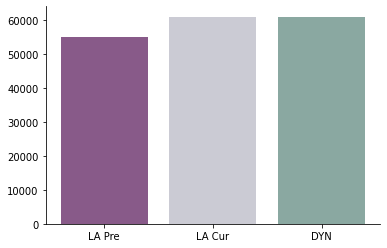

In [8]:
plt.bar(["LA Pre", "LA Cur", "DYN"], [LA_pre_mean_ave, LA_curr_mean_ave, DYN_mean_ave], color=[samplers_color[1], samplers_color[2], samplers_color[0]])


<BarContainer object of 3 artists>

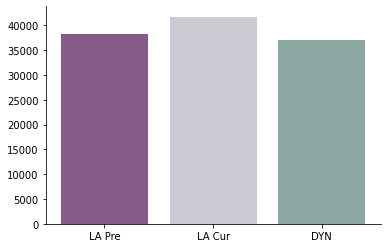

In [9]:
plt.bar(["LA Pre", "LA Cur", "DYN"], [LA_pre_median_ave, LA_curr_median_ave, DYN_median_ave], color=[samplers_color[1], samplers_color[2], samplers_color[0]])

## Over all speed-up - 800 sec

In [10]:
mean = lambda x, y: np.mean(1 - np.array(x) / np.array(y))
median = lambda x, y: np.median(1 - np.array(x) / np.array(y))

SETTINGS = ["250N_128W", "250N_128W", "500N_128W", "500N_128W", "500N_256W", "500N_256W", "1000N_256W", "1000N_256W"]

def grouped_mean(x, y, s):
    # group by setting
    s_cats = pd.Series(range(len(s))).groupby(s, sort=False).apply(list).tolist()
    # calculate mean per setting
    means_x = [np.mean([x[i] for i in s_cat]) for s_cat in s_cats]
    means_y = [np.mean([y[i] for i in s_cat]) for s_cat in s_cats]
    # calculate mean speed-up across settings
    return mean(means_x, means_y)

def grouped_median(x, y, s):
    # group by setting
    s_cats = pd.Series(range(len(s))).groupby(s, sort=False).apply(list).tolist()
    # calculate mean per setting
    medians_x = [np.median([x[i] for i in s_cat]) for s_cat in s_cats]
    medians_y = [np.median([y[i] for i in s_cat]) for s_cat in s_cats]
    # calculate mean speed-up across settings
    return median(medians_x, medians_y)

# M1



print("M2")
print("LA Pre vs DYN:", "mean", mean(LA_pre_mean_all, DYN_mean_all), "median", median(LA_pre_mean_all, DYN_mean_all))
print("LA Cur vs DYN:", "mean", mean(LA_curr_mean_all, DYN_mean_all), "median", median(LA_curr_mean_all, DYN_mean_all))

print("M2 grouped")
print("LA Pre vs DYN:", "mean", grouped_mean(LA_pre_mean_all, DYN_mean_all, SETTINGS), "median", grouped_median(LA_pre_mean_all, DYN_mean_all, SETTINGS))
print("LA Cur vs DYN:", "mean", grouped_mean(LA_curr_mean_all, DYN_mean_all, SETTINGS), "median", grouped_median(LA_curr_mean_all, DYN_mean_all, SETTINGS))


M2
LA Pre vs DYN: mean -0.08967766535885899 median 0.07020386337809453
LA Cur vs DYN: mean -0.6241283876248295 median 0.12259671849030301
M2 grouped
LA Pre vs DYN: mean 0.0076211929160096 median 0.13692157448677955
LA Cur vs DYN: mean -0.3248438483755758 median 0.18192103227136985


## CI

In [11]:
from pyabc.visualization.credible import compute_quantile, compute_credible_interval
from typing import List, Union

#df_LA, w_LA = history_DLA.get_distribution(m=m, t=history_DLA.max_t)
#df_DYN, w_DYN = history_ORI.get_distribution(m=m, t=history_ORI.max_t)
def get_intervals(history, par_names: List = None, levels: List = [0.5,0.95], t_curr=0):
    if par_names is None:
        # extract all parameter names
        df, _ = history.get_distribution(m=0)
        par_names = list(df.columns.values)
    
    median = np.empty((len(par_names)))
    cis = np.empty((len(par_names),2*len(levels)))
    
    df, w = history.get_distribution(m=0, t=t_curr)
    # normalize weights to be sure
    w /= w.sum()
    
    for i_par, par in enumerate(par_names):
        # as numpy array
        vals = np.array(df[par])
        # median
        median[i_par] = compute_quantile(vals, w, 0.5)
        # levels
        for i_c, confidence in enumerate(levels):
            lb, ub = compute_credible_interval(
                vals, w, confidence)
            cis[i_par, i_c] = lb
            cis[i_par, -1 - i_c] = ub
    return median, cis

def plot_intervals(median, cis, ax=None, alpha=0.3,
                   par_names: List = None,
                   levels: List = [0.5,0.95],
                   offset: float=0,
                   color: str = None):
    if par_names is None:
        # extract all parameter names
        df, _ = history.get_distribution(m=0)
        par_names = list(df.columns.values)

    for i_par, par in enumerate(par_names):
        for i_c, confidence in reversed(list(enumerate(levels))):
            ax.hlines(i_par+offset,
                      cis[i_par, i_c],
                      cis[i_par, -1 - i_c],
                      linewidth=6/len(levels)*(len(levels)-i_c),
                      alpha = 1/len(levels)*(len(levels)-i_c),
                      color=color)
            ax.vlines(median[i_par],offset+i_par-0.15,offset+i_par+0.15, color="black", alpha=alpha)
    xmin,xmax=ax.get_xlim()
    for i_par, par in enumerate(par_names):
        ax.hlines(i_par+0.5,xmin, xmax, color="black", linewidth=0.5, linestyle="dashed", alpha=0.1)
    ax.set_xlim(xmin,xmax)        

### N1000/500 W=256

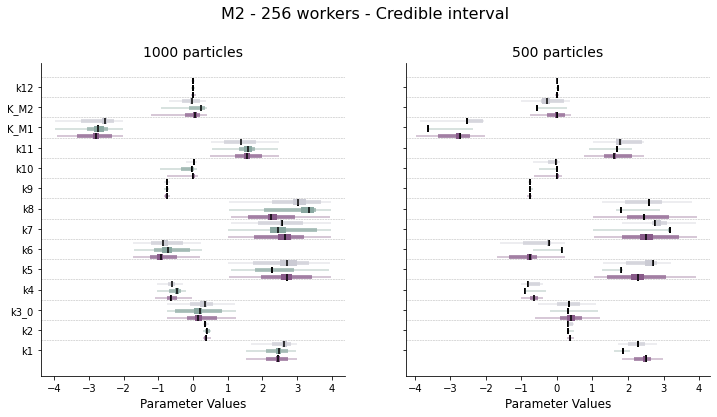

In [12]:
worker_size = 256


sampler_labels_set1 = ["liver_1000_256", "liver_1000_256_ORI", "liver_1000_256_la_pre"]
sampler_labels_set2 = ["liver_500_256", "liver_500_256_ORI", "liver_500_256_la_pre"]

population_index = {"liver_1000_256_1": 16, "liver_1000_256_2": 16,
                    "liver_1000_256_ORI_1": 17, "liver_1000_256_ORI_2": 16, "liver_1000_256_ORI_1_confirmation": 16,
                    "liver_1000_256_la_pre_1": 16,"liver_1000_256_la_pre_2": 16,
                   "liver_500_256_1": 15, "liver_500_256_2": 14, 
                    "liver_500_256_ORI_1": 11, "liver_500_256_ORI_2": 15, "liver_500_256_ORI_1_confirmation": 16, "liver_500_256_ORI_2_confirmation": 12, 
                    "liver_500_256_la_pre_1": 15,"liver_500_256_la_pre_2": 17,
}

parameter_names=["k1", "k2", "k3_0", "k4",
                "k5", "k6", "k7", "k8",
                "k9", "k10", "k11", "K_M1",
                "K_M2", "intensity_normalization_total"
]

names={"k1": "Max. flux of SENSOR activation", "k2": "Max. flux of SENSOR inactivation",
                "k3_0": "Factor of YAP synthesis rate", "k4": "YAP inactivation rate",
                "k5": "YAP activation rate", "k6": "Inact YAP binding rate to SF",
                "k7": "Inact YAP unbin. rate from SF", "k8": "YAP export rate from nucleus",
                "k9": "YAP import rate into nucleus", "k10": "YAP degradation rate",
                "k11": "Inact YAP degradation rate", "K_M1": "M-M const. of SENSOR activation",
                "K_M2": "Max. flux of SENSOR inactivation",
                "intensity_normalization_total": "Intensity normalization total"}

names={"k1": "k1",
       "k2": "k2",
       "k3_0": "k3_0",
       "k4": "k4",
        "k5": "k5",
       "k6": "k6",
       "k7": "k7",
       "k8": "k8",
        "k9": "k9",
       "k10": "k10",
       "k11": "k11",
       "K_M1": "K_M1",
       "K_M2": "K_M2",
       "intensity_normalization_total": "k12"
}



iters = 1
levels = [0.1,0.5,0.99]
fig, ax = plt.subplots(1,2,figsize=(12,6))
offset = 0.3
for sampler_index, sampler_label in enumerate(sampler_labels_set1):
    times_for_sampler = []
    samples_for_sampler = []
    for ix in range(iters):
        if f"{sampler_label}_{str(ix+1)}" in ["liver_1000_256_ORI_1", "liver_500_256_ORI_1", "liver_500_256_ORI_2"]:
            sampler_db = f"{sampler_label}_{str(ix+1)}_confirmation"
            pop_index = population_index[f"{sampler_label}_{str(ix+1)}_confirmation"]
        else:
            sampler_db = f"{sampler_label}_{str(ix+1)}"
            pop_index = population_index[f"{sampler_label}_{str(ix+1)}"]

        h = pyabc.History(
            f"sqlite:///{gp}/{sampler_db}.db", create=False)
        median, cis = get_intervals(h, par_names=parameter_names, levels=levels, t_curr=pop_index-1)
#         median14, cis14 = get_intervals(history714, par_names=parameter_names, levels=levels, t_curr=13)

        plot_intervals(median, cis, par_names=parameter_names, ax=ax[0], levels=levels, offset=offset, color=colors_map_eps[sampler_label], alpha=1)
#         plot_intervals(median14, cis14, par_names=parameter_names, levels=levels, offset=-0.15, color = sim_color14)

        ax[0].set_yticks(range(len(parameter_names)))
        ax[0].set_yticklabels([names[parameter_names[i]] for i in range(len(parameter_names))], rotation=0)
        ax[0].set_xlabel("Parameter Values", fontsize=12)
        ax[0].spines['top'].set_visible(False)
        ax[0].spines['right'].set_visible(False)

        for i_c, confidence in reversed(list(enumerate(levels))):
            ax[0].hlines(0,0,0,
                      linewidth=10/len(levels)*(len(levels)-i_c),
                      alpha = 1/len(levels)*(len(levels)-i_c),
                      color="black",
                      label=str(int(100*confidence))+"% Quantile")

        ax[0].hlines(0,0,0, linewidth=10, alpha=1)
#         ax.hlines(0,0,0, linewidth=10, alpha=1, color=sim_color, label="7 param L1+Ada.+MAD+SensiLR+Manual - 32 nodes")
        #ax.vlines(0,0,0, color="black", label="Medians")

#         ax[0].legend(loc=1)
        offset = offset-0.35

offset = 0.3
levels = [0.1,0.5,0.99]

for sampler_index, sampler_label in enumerate(sampler_labels_set2):
    times_for_sampler = []
    samples_for_sampler = []
    for ix in range(iters):
        if f"{sampler_label}_{str(ix+1)}" in ["liver_1000_256_ORI_1", "liver_500_256_ORI_1", "liver_500_256_ORI_2"]:
            sampler_db = f"{sampler_label}_{str(ix+1)}_confirmation"
            pop_index = population_index[f"{sampler_label}_{str(ix+1)}_confirmation"]
        else:
            sampler_db = f"{sampler_label}_{str(ix+1)}"
            pop_index = population_index[f"{sampler_label}_{str(ix+1)}"]

        h = pyabc.History(
            f"sqlite:///{gp}/{sampler_db}.db", create=False)
        median, cis = get_intervals(h, par_names=parameter_names, levels=levels, t_curr=pop_index-1)
#         median14, cis14 = get_intervals(history714, par_names=parameter_names, levels=levels, t_curr=13)

        plot_intervals(median, cis, par_names=parameter_names, ax=ax[1], levels=levels, offset=offset, color=colors_map_eps[sampler_label], alpha=1)
#         plot_intervals(median14, cis14, par_names=parameter_names, levels=levels, offset=-0.15, color = sim_color14)

        ax[1].set_yticks(range(len(parameter_names)))
        ax[1].set_yticklabels("")
        ax[1].set_xlabel("Parameter Values", fontsize=12)
        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)

        for i_c, confidence in reversed(list(enumerate(levels))):
            ax[1].hlines(0,0,0,
                      linewidth=10/len(levels)*(len(levels)-i_c),
                      alpha = 1/len(levels)*(len(levels)-i_c),
                      color="black",
                      label=str(int(100*confidence))+"% Quantile")

        ax[1].hlines(0,0,0, linewidth=10, alpha=1)
#         ax.hlines(0,0,0, linewidth=10, alpha=1, color=sim_color, label="7 param L1+Ada.+MAD+SensiLR+Manual - 32 nodes")
        #ax.vlines(0,0,0, color="black", label="Medians")

#         ax[0].legend(loc=1)
        offset = offset-0.35

ax[0].set_title("1000 particles", fontsize=14)
ax[1].set_title("500 particles", fontsize=14)


fig.suptitle(f"M2 - {worker_size} workers - Credible interval", fontsize=16)
fig.subplots_adjust(top=0.85)

plt.savefig(f"M2_figures/M2_CI_1000_500px{worker_size}w.pdf", format="pdf", bbox_inches="tight")



### N=500/250, W=128

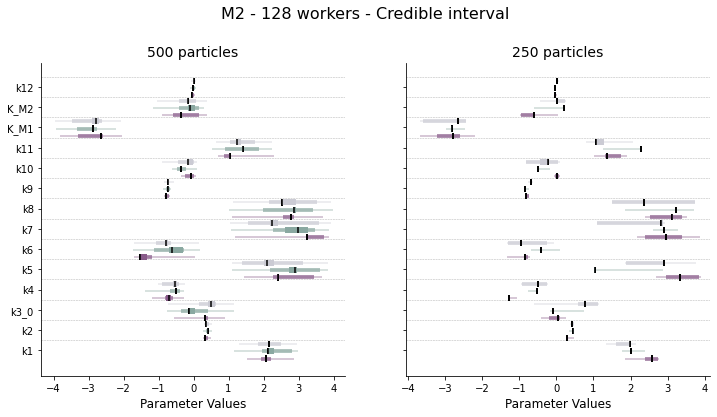

In [13]:
worker_size = 128

sampler_labels_set1 = ["liver_500_128", "liver_500_128_ORI", "liver_500_128_la_pre"]
sampler_labels_set2 = ["liver_250_128", "liver_250_128_ORI", "liver_250_128_la_pre"]



population_index = {"liver_500_128_1": 12, "liver_500_128_2": 10,
                    "liver_500_128_ORI_1": 13, "liver_500_128_ORI_2": 11,
                    "liver_500_128_la_pre_1": 12,"liver_500_128_la_pre_2": 12,
                   "liver_250_128_1": 10, "liver_250_128_2": 9, 
                    "liver_250_128_ORI_1": 11, "liver_250_128_ORI_2": 7,
                    "liver_250_128_la_pre_1": 13,"liver_250_128_la_pre_2": 15,
}

parameter_names=["k1", "k2", "k3_0", "k4",
                "k5", "k6", "k7", "k8",
                "k9", "k10", "k11", "K_M1",
                "K_M2", "intensity_normalization_total"
]

names=["k1", "k2", "k3_0", "k4",
                "k5", "k6", "k7", "k8",
                "k9", "k10", "k11", "K_M1",
                "K_M2", "intensity_normalization_total"
]


names={"k1": "Max. flux of SENSOR activation", "k2": "Max. flux of SENSOR inactivation",
                "k3_0": "Factor of YAP synthesis rate", "k4": "YAP inactivation rate",
                "k5": "YAP activation rate", "k6": "Inact YAP binding rate to SF",
                "k7": "Inact YAP unbin. rate from SF", "k8": "YAP export rate from nucleus",
                "k9": "YAP import rate into nucleus", "k10": "YAP degradation rate",
                "k11": "Inact YAP degradation rate", "K_M1": "M-M const. of SENSOR activation",
                "K_M2": "Max. flux of SENSOR inactivation",
                "intensity_normalization_total": "Intensity normalization total"}

names={"k1": "k1",
       "k2": "k2",
       "k3_0": "k3_0",
       "k4": "k4",
        "k5": "k5",
       "k6": "k6",
       "k7": "k7",
       "k8": "k8",
        "k9": "k9",
       "k10": "k10",
       "k11": "k11",
       "K_M1": "K_M1",
       "K_M2": "K_M2",
       "intensity_normalization_total": "k12"
}


iters = 1
levels = [0.1,0.5,0.99]
fig, ax = plt.subplots(1,2,figsize=(12,6))
offset = 0.3
for sampler_index, sampler_label in enumerate(sampler_labels_set1):
    times_for_sampler = []
    samples_for_sampler = []
    for ix in range(iters):
        if f"{sampler_label}_{str(ix+1)}" in ["liver_1000_256_ORI_1", "liver_500_256_ORI_1", "liver_500_256_ORI_2"]:
            sampler_db = f"{sampler_label}_{str(ix+1)}_confirmation"
            pop_index = population_index[f"{sampler_label}_{str(ix+1)}_confirmation"]
        else:
            sampler_db = f"{sampler_label}_{str(ix+1)}"
            pop_index = population_index[f"{sampler_label}_{str(ix+1)}"]

        h = pyabc.History(
            f"sqlite:///{gp}/{sampler_db}.db", create=False)
        median, cis = get_intervals(h, par_names=parameter_names, levels=levels, t_curr=pop_index-1)
#         median14, cis14 = get_intervals(history714, par_names=parameter_names, levels=levels, t_curr=13)

        plot_intervals(median, cis, par_names=parameter_names, ax=ax[0], levels=levels, offset=offset, color=colors_map_eps[sampler_label], alpha=1)
#         plot_intervals(median14, cis14, par_names=parameter_names, levels=levels, offset=-0.15, color = sim_color14)

        ax[0].set_yticks(range(len(parameter_names)))
        ax[0].set_yticklabels([names[parameter_names[i]] for i in range(len(parameter_names))], rotation=0)
        ax[0].set_xlabel("Parameter Values", fontsize=12)
        ax[0].spines['top'].set_visible(False)
        ax[0].spines['right'].set_visible(False)

        for i_c, confidence in reversed(list(enumerate(levels))):
            ax[0].hlines(0,0,0,
                      linewidth=10/len(levels)*(len(levels)-i_c),
                      alpha = 1/len(levels)*(len(levels)-i_c),
                      color="black",
                      label=str(int(100*confidence))+"% Quantile")

        ax[0].hlines(0,0,0, linewidth=10, alpha=1)
#         ax.hlines(0,0,0, linewidth=10, alpha=1, color=sim_color, label="7 param L1+Ada.+MAD+SensiLR+Manual - 32 nodes")
        #ax.vlines(0,0,0, color="black", label="Medians")

#         ax[0].legend(loc=1)
        offset = offset-0.35

offset = 0.3
levels = [0.1,0.5,0.99]

for sampler_index, sampler_label in enumerate(sampler_labels_set2):
    times_for_sampler = []
    samples_for_sampler = []
    for ix in range(iters):
        if f"{sampler_label}_{str(ix+1)}" in ["liver_1000_256_ORI_1", "liver_500_256_ORI_1", "liver_500_256_ORI_2"]:
            sampler_db = f"{sampler_label}_{str(ix+1)}_confirmation"
            pop_index = population_index[f"{sampler_label}_{str(ix+1)}_confirmation"]
        else:
            sampler_db = f"{sampler_label}_{str(ix+1)}"
            pop_index = population_index[f"{sampler_label}_{str(ix+1)}"]

        h = pyabc.History(
            f"sqlite:///{gp}/{sampler_db}.db", create=False)
        median, cis = get_intervals(h, par_names=parameter_names, levels=levels, t_curr=pop_index-1)
#         median14, cis14 = get_intervals(history714, par_names=parameter_names, levels=levels, t_curr=13)

        plot_intervals(median, cis, par_names=parameter_names, ax=ax[1], levels=levels, offset=offset, color=colors_map_eps[sampler_label], alpha=1)
#         plot_intervals(median14, cis14, par_names=parameter_names, levels=levels, offset=-0.15, color = sim_color14)

        ax[1].set_yticks(range(len(parameter_names)))
        ax[1].set_yticklabels("")
        ax[1].set_xlabel("Parameter Values", fontsize=12)
        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)

        for i_c, confidence in reversed(list(enumerate(levels))):
            ax[1].hlines(0,0,0,
                      linewidth=10/len(levels)*(len(levels)-i_c),
                      alpha = 1/len(levels)*(len(levels)-i_c),
                      color="black",
                      label=str(int(100*confidence))+"% Quantile")

        ax[1].hlines(0,0,0, linewidth=10, alpha=1)
#         ax.hlines(0,0,0, linewidth=10, alpha=1, color=sim_color, label="7 param L1+Ada.+MAD+SensiLR+Manual - 32 nodes")
        #ax.vlines(0,0,0, color="black", label="Medians")

#         ax[0].legend(loc=1)
        offset = offset-0.35

ax[0].set_title("500 particles", fontsize=14)
ax[1].set_title("250 particles", fontsize=14)


fig.suptitle(f"M2 - {worker_size} workers - Credible interval", fontsize=16)
fig.subplots_adjust(top=0.85)

plt.savefig(f"M2_figures/M2_CI_500_250px{worker_size}w.pdf", format="pdf", bbox_inches="tight")


# ###########################################

## Configration 2, simulation time maximum limit=1800

# 256 cores on population size of = 1000 and 500 (Eps <1.50e+03)

In [14]:
gp = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + "/Data/Model_M2/1800_db"

h = pyabc.History(f"sqlite:///{gp}/liver_250_128_ORI_2.db", create=False)
h.get_all_populations()


,t,population_end_time,samples,epsilon,particles
0,-1,2023-04-24 12:37:33.477514,250,inf,1
1,0,2023-04-24 13:09:01.420472,884,4.991091e+04,250
2,1,2023-04-24 13:39:47.904320,1223,2.309537e+04,250
3,2,2023-04-24 14:06:13.464617,1168,9.815171e+03,250
4,3,2023-04-24 14:37:20.965078,1497,6.125246e+03,250
5,4,2023-04-24 15:07:38.741419,1349,4.263667e+03,250
6,5,2023-04-24 15:34:35.621089,1591,3.315409e+03,250
7,6,2023-04-24 15:45:19.262889,1417,2.946326e+03,250
8,7,2023-04-24 15:54:01.069997,1721,2.719571e+03,250
9,8,2023-04-24 15:59:59.260560,2265,2.613434e+03,250


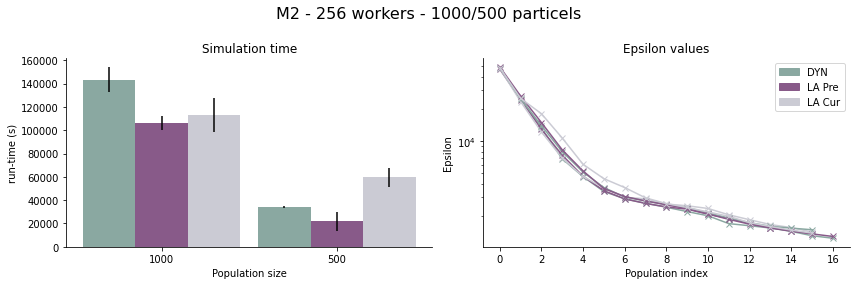

In [15]:
colors_map_eps = {'liver_500_256':samplers_color[2], 'liver_1000_256':samplers_color[2],
              'liver_500_256_ORI':samplers_color[0], 'liver_1000_256_ORI':samplers_color[0],
             'liver_500_256_la_pre':samplers_color[1], 'liver_1000_256_la_pre':samplers_color[1],
                 'liver_250_128':samplers_color[2], 'liver_500_128':samplers_color[2],
              'liver_250_128_ORI':samplers_color[0], 'liver_500_128_ORI':samplers_color[0],
             'liver_250_128_la_pre':samplers_color[1], 'liver_500_128_la_pre':samplers_color[1]}         


pyabc.settings.set_figure_params("pyabc")

sampler_labels = ["liver_1000_256", "liver_1000_256_ORI", "liver_1000_256_la_pre",
                  "liver_500_256", "liver_500_256_ORI", "liver_500_256_la_pre"]

sampler = "data_la"
model_id = "TumorRes"

pop_size = 1000
worker_size = 256
sigma = 0.5
iters = 2


population_index = {"liver_1000_256_1": 15, "liver_1000_256_2": 15,
                    "liver_1000_256_ORI_1": 16, "liver_1000_256_ORI_2": 16,
                    "liver_1000_256_la_pre_1": 15,"liver_1000_256_la_pre_2": 15,
                   "liver_500_256_1": 16, "liver_500_256_2": 14, 
                    "liver_500_256_ORI_1": 14, "liver_500_256_ORI_2": 18,
                    "liver_500_256_la_pre_1": 14,"liver_500_256_la_pre_2": 12,
                   }
times = []
samples = []
time_new = {}
sample_new = {}
for sampler_label in sampler_labels:
    times_for_sampler = []
    samples_for_sampler = []
    for ix in range(iters):
        sampler_db = f"{sampler_label}_{str(ix+1)}"
        h = pyabc.History(
            f"sqlite:///{gp}/{sampler_db}.db", create=False)
        abc = h.get_abc()
        if abc.end_time is None:
            times_for_sampler.append(
                (h.get_all_populations()["population_end_time"][population_index[sampler_db]] - abc.start_time).total_seconds())
        else:
            times_for_sampler.append(
                (abc.end_time - abc.start_time).total_seconds())
        samples_for_sampler.append(list(h.get_all_populations()["samples"]))
    time_new[sampler_label] = times_for_sampler
    sample_new[sampler_label] = samples_for_sampler

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))


x = np.arange(2)
f_width = 0.3

axes[0].bar(
    x-0.3,
    height=[np.mean(time_new["liver_1000_256_ORI"]), np.mean(time_new["liver_500_256_ORI"])],
    width = f_width,
    yerr=[np.std(time_new["liver_1000_256_ORI"]), np.std(time_new["liver_500_256_ORI"])],
    color=colors_map["DYN"]
)


axes[0].bar(
    x,
    height=[np.mean(time_new["liver_1000_256_la_pre"]), np.mean(time_new["liver_500_256_la_pre"])],
    width = f_width,
    yerr=[np.std(time_new["liver_1000_256_la_pre"]), np.std(time_new["liver_500_256_la_pre"])],
    color=colors_map["LA_pre"]

)
axes[0].bar(
    x+0.3,
    height=[np.mean(time_new["liver_1000_256"]), np.mean(time_new["liver_500_256"])],
    width = f_width,
    yerr=[np.std(time_new["liver_1000_256"]), np.std(time_new["liver_500_256"])],
    color=colors_map["LA"]
)

axes[0].set_xticks(x, ['1000', '500'])
axes[0].set_xlabel("Population size")
axes[0].set_ylabel("run-time (s)")
# axes[0].legend(["LA", "DYN", "LA_pre"])
axes[0].set_title("Simulation time")




db_list = []
for sampler_ix, sampler_label in enumerate(sampler_labels):
    for ix in range(iters):
        h = pyabc.History(
            f"sqlite:///{gp}/{sampler_label}_{str(ix+1)}.db", create=False)
        db_list.append(h)
pyabc.visualization.plot_epsilons(db_list, ax=axes[1], colors=samplers_color_double)
labels = list(colors_map.keys())

DYN_patch = mpatches.Patch(color=samplers_color[0], label='DYN')
Pre_patch = mpatches.Patch(color=samplers_color[1], label='LA Pre')
Curr_patch = mpatches.Patch(color=samplers_color[2], label='LA Cur')
axes[1].legend(handles=[DYN_patch, Pre_patch, Curr_patch])

# axes[1].legend()
fig.suptitle(f"M2 - {worker_size} workers - 1000/500 particels", fontsize=16)
fig.tight_layout()

fig.subplots_adjust(top=0.80)
plt.savefig(f"M2_figures/M2_1800_time_epsilon_1000_500px{worker_size}w.pdf", format="pdf", bbox_inches="tight")


In [16]:
LA_pre_mean_256 = []
LA_curr_mean_256 = []
DYN_mean_256 = []
LA_pre_mean_256 = time_new["liver_500_256_la_pre"] + time_new["liver_1000_256_la_pre"]
LA_curr_mean_256 = time_new["liver_500_256"] + time_new["liver_1000_256"]
DYN_mean_256 = time_new["liver_500_256_ORI"] + time_new["liver_1000_256_ORI"]

LA_pre_median_256 = []
LA_curr_median_256 = []
DYN_median_256 = []
LA_pre_median_256 = time_new["liver_500_256_la_pre"] + time_new["liver_1000_256_la_pre"]
LA_curr_median_256 = time_new["liver_500_256"] + time_new["liver_1000_256"]
DYN_median_256 = time_new["liver_500_256_ORI"] + time_new["liver_1000_256_ORI"]


# 128 cores on population size of = 500 and 250 (Eps <1.50e+03)

{'liver_500_128': [70892.512562, 85998.697747], 'liver_500_128_ORI': [73990.404161, 65051.211571], 'liver_500_128_la_pre': [50807.372478, 68926.945209], 'liver_250_128': [64724.181581, 45165.223309], 'liver_250_128_ORI': [38788.131943, 19152.877487], 'liver_250_128_la_pre': [10908.36225, 7242.864004]}


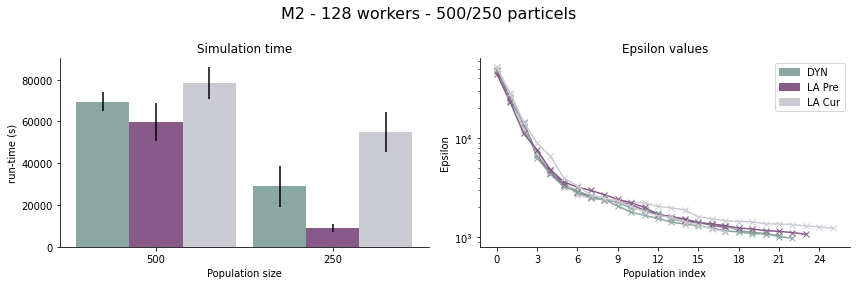

In [17]:

pyabc.settings.set_figure_params("pyabc")

sampler_labels = ["liver_500_128", "liver_500_128_ORI", "liver_500_128_la_pre",
                  "liver_250_128", "liver_250_128_ORI", "liver_250_128_la_pre"]

sampler = "data_la"
model_id = "TumorRes"

pop_size = 1000
worker_size = 128
sigma = 0.5
iters = 2


population_index = {"liver_500_128_1": 14, "liver_500_128_2": 16,
                    "liver_500_128_ORI_1": 18, "liver_500_128_ORI_2": 15,
                    "liver_500_128_la_pre_1": 15,"liver_500_128_la_pre_2": 15,
                   "liver_250_128_1": 16, "liver_250_128_2": 17, 
                    "liver_250_128_ORI_1": 18, "liver_250_128_ORI_2": 18,
                    "liver_250_128_la_pre_1": 18,"liver_250_128_la_pre_2": 14,
}
times = []
samples = []
time_new = {}
sample_new = {}
for sampler_label in sampler_labels:
    times_for_sampler = []
    samples_for_sampler = []
    for ix in range(iters):
        sampler_db = f"{sampler_label}_{str(ix+1)}"
        h = pyabc.History(
            f"sqlite:///{gp}/{sampler_db}.db", create=False)
        abc = h.get_abc()
        if abc.end_time is None:
            times_for_sampler.append(
                (h.get_all_populations()["population_end_time"][population_index[sampler_db]] - abc.start_time).total_seconds())
        else:
            times_for_sampler.append(
                (abc.end_time - abc.start_time).total_seconds())
        samples_for_sampler.append(list(h.get_all_populations()["samples"]))
    time_new[sampler_label] = times_for_sampler
    sample_new[sampler_label] = samples_for_sampler

#     samples.append(samples_for_sampler)
#     times.append(times_for_sampler)
# print("time=", times)

# times = np.array(times)
# times /= np.max(np.mean(times, axis=1))
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
print(time_new)


x = np.arange(2)
f_width = 0.3

axes[0].bar(
    x-0.3,
    height=[np.mean(time_new["liver_500_128_ORI"]), np.mean(time_new["liver_250_128_ORI"])],
    width = f_width,
    yerr=[np.std(time_new["liver_500_128_ORI"]), np.std(time_new["liver_250_128_ORI"])],
    color=colors_map["DYN"]
)


axes[0].bar(
    x,
    height=[np.mean(time_new["liver_500_128_la_pre"]), np.mean(time_new["liver_250_128_la_pre"])],
    width = f_width,
    yerr=[np.std(time_new["liver_500_128_la_pre"]), np.std(time_new["liver_250_128_la_pre"])],
    color=colors_map["LA_pre"]

)
axes[0].bar(
    x+0.3,
    height=[np.mean(time_new["liver_500_128"]), np.mean(time_new["liver_250_128"])],
    width = f_width,
    yerr=[np.std(time_new["liver_500_128"]), np.std(time_new["liver_250_128"])],
    color=colors_map["LA"]
)

axes[0].set_xticks(x, ['500', '250'])
axes[0].set_xlabel("Population size")
axes[0].set_ylabel("run-time (s)")
# axes[0].legend(["LA", "DYN", "LA_pre"])
axes[0].set_title("Simulation time")



db_list = []
for sampler_ix, sampler_label in enumerate(sampler_labels):
    for ix in range(iters):
        h = pyabc.History(
            f"sqlite:///{gp}/{sampler_label}_{str(ix+1)}.db", create=False)
        db_list.append(h)
pyabc.visualization.plot_epsilons(db_list, ax=axes[1], colors=samplers_color_double)
labels = list(colors_map.keys())

DYN_patch = mpatches.Patch(color=samplers_color[0], label='DYN')
Pre_patch = mpatches.Patch(color=samplers_color[1], label='LA Pre')
Curr_patch = mpatches.Patch(color=samplers_color[2], label='LA Cur')
axes[1].legend(handles=[DYN_patch, Pre_patch, Curr_patch])

# axes[1].legend()
fig.suptitle(f"M2 - {worker_size} workers - 500/250 particels", fontsize=16)
fig.tight_layout()

fig.subplots_adjust(top=0.80)
plt.savefig(f"M2_figures/M2_1800_time_epsilon_500_250px{worker_size}w.pdf", format="pdf", bbox_inches="tight")


In [18]:
LA_pre_mean_128 = []
LA_curr_mean_128 = []
DYN_mean_128 = []
LA_pre_mean_128 = time_new["liver_250_128_la_pre"] + time_new["liver_500_128_la_pre"]
LA_curr_mean_128 = time_new["liver_250_128"] + time_new["liver_500_128"]
DYN_mean_128 = time_new["liver_250_128_ORI"] + time_new["liver_500_128_ORI"]

LA_pre_median_128 = []
LA_curr_median_128 = []
DYN_median_128 = []
LA_pre_median_128 = time_new["liver_250_128_la_pre"] + time_new["liver_500_128_la_pre"]
LA_curr_median_128 = time_new["liver_250_128"] + time_new["liver_500_128"]
DYN_median_128 = time_new["liver_250_128_ORI"] + time_new["liver_500_128_ORI"]


LA_pre_mean_all = LA_pre_mean_128 + LA_pre_mean_256
LA_curr_mean_all = LA_curr_mean_128 + LA_curr_mean_256
DYN_mean_all =  DYN_mean_128 + DYN_mean_256

LA_pre_mean_ave= np.mean(LA_pre_mean_all)
LA_curr_mean_ave= np.mean(LA_curr_mean_all)
DYN_mean_ave = np.mean(DYN_mean_all)

LA_pre_median_all = LA_pre_median_128 + LA_pre_median_256
LA_curr_median_all = LA_curr_median_128 + LA_curr_median_256
DYN_median_all = DYN_median_128 + DYN_median_256

LA_pre_median_ave= np.median(LA_pre_median_all)
LA_curr_median_ave= np.median(LA_curr_median_all)
DYN_median_ave = np.median(DYN_median_all)


<BarContainer object of 3 artists>

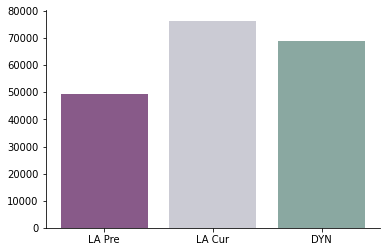

In [19]:
plt.bar(["LA Pre", "LA Cur", "DYN"], [LA_pre_mean_ave, LA_curr_mean_ave, DYN_mean_ave], color=[samplers_color[1], samplers_color[2], samplers_color[0]])


<BarContainer object of 3 artists>

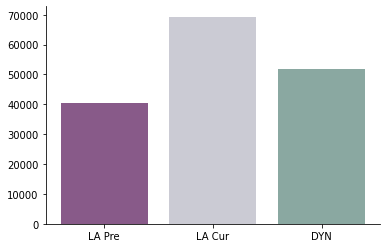

In [20]:
plt.bar(["LA Pre", "LA Cur", "DYN"], [LA_pre_median_ave, LA_curr_median_ave, DYN_median_ave], color=[samplers_color[1], samplers_color[2], samplers_color[0]])

## Over all speed-up

In [21]:
mean = lambda x, y: np.mean(1 - np.array(x) / np.array(y))
median = lambda x, y: np.median(1 - np.array(x) / np.array(y))

SETTINGS = ["250N_128W", "250N_128W", "500N_128W", "500N_128W", "500N_256W", "500N_256W", "1000N_256W", "1000N_256W"]

def grouped_mean(x, y, s):
    # group by setting
    s_cats = pd.Series(range(len(s))).groupby(s, sort=False).apply(list).tolist()
    # calculate mean per setting
    means_x = [np.mean([x[i] for i in s_cat]) for s_cat in s_cats]
    means_y = [np.mean([y[i] for i in s_cat]) for s_cat in s_cats]
    # calculate mean speed-up across settings
    return mean(means_x, means_y)

def grouped_median(x, y, s):
    # group by setting
    s_cats = pd.Series(range(len(s))).groupby(s, sort=False).apply(list).tolist()
    # calculate mean per setting
    medians_x = [np.median([x[i] for i in s_cat]) for s_cat in s_cats]
    medians_y = [np.median([y[i] for i in s_cat]) for s_cat in s_cats]
    # calculate mean speed-up across settings
    return median(medians_x, medians_y)

# M2



print("M2")
print("LA Pre vs DYN:", "mean", mean(LA_pre_mean_all, DYN_mean_all), "median", median(LA_pre_mean_all, DYN_mean_all))
print("LA Cur vs DYN:", "mean", mean(LA_curr_mean_all, DYN_mean_all), "median", median(LA_curr_mean_all, DYN_mean_all))

print("M2 grouped")
print("LA Pre vs DYN:", "mean", grouped_mean(LA_pre_mean_all, DYN_mean_all, SETTINGS), "median", grouped_median(LA_pre_mean_all, DYN_mean_all, SETTINGS))
print("LA Cur vs DYN:", "mean", grouped_mean(LA_curr_mean_all, DYN_mean_all, SETTINGS), "median", grouped_median(LA_curr_mean_all, DYN_mean_all, SETTINGS))


M2
LA Pre vs DYN: mean 0.35016130294057607 median 0.33081865206369493
LA Cur vs DYN: mean -0.4245543209367941 median -0.3875344621628727
M2 grouped
LA Pre vs DYN: mean 0.36082372280062724 median 0.30885291903436424
LA Cur vs DYN: mean -0.3874116617629644 median -0.43264752338354173


## CI

### N=1000/500, W=256

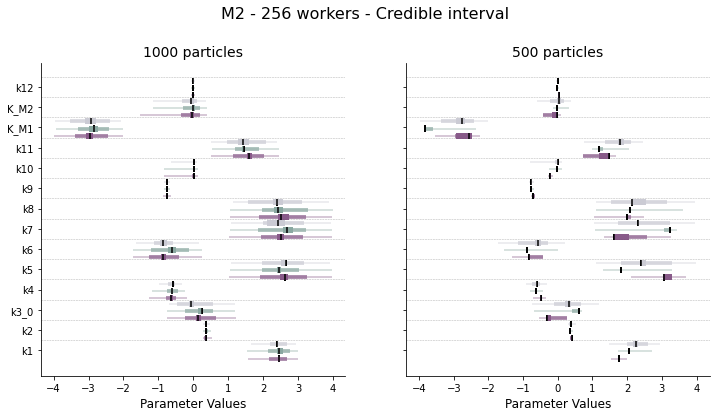

In [22]:
worker_size = 256

sampler_labels_set1 = ["liver_1000_256", "liver_1000_256_ORI", "liver_1000_256_la_pre"]
sampler_labels_set2 = ["liver_500_256", "liver_500_256_ORI", "liver_500_256_la_pre"]

population_index = {"liver_1000_256_1": 15, "liver_1000_256_2": 0,
                    "liver_1000_256_ORI_1": 16, "liver_1000_256_ORI_2": 0,
                    "liver_1000_256_la_pre_1": 15,"liver_1000_256_la_pre_2": 0,
                   "liver_500_256_1": 16, "liver_500_256_2": 0, 
                    "liver_500_256_ORI_1": 14, "liver_500_256_ORI_2": 0,
                    "liver_500_256_la_pre_1": 14,"liver_500_256_la_pre_2": 0,
                   }

parameter_names=["k1", "k2", "k3_0", "k4",
                "k5", "k6", "k7", "k8",
                "k9", "k10", "k11", "K_M1",
                "K_M2", "intensity_normalization_total"
]

names={"k1": "Max. flux of SENSOR activation", "k2": "Max. flux of SENSOR inactivation",
                "k3_0": "Factor of YAP synthesis rate", "k4": "YAP inactivation rate",
                "k5": "YAP activation rate", "k6": "Inact YAP binding rate to SF",
                "k7": "Inact YAP unbin. rate from SF", "k8": "YAP export rate from nucleus",
                "k9": "YAP import rate into nucleus", "k10": "YAP degradation rate",
                "k11": "Inact YAP degradation rate", "K_M1": "M-M const. of SENSOR activation",
                "K_M2": "Max. flux of SENSOR inactivation",
                "intensity_normalization_total": "Intensity normalization total"}

names={"k1": "k1",
       "k2": "k2",
       "k3_0": "k3_0",
       "k4": "k4",
        "k5": "k5",
       "k6": "k6",
       "k7": "k7",
       "k8": "k8",
        "k9": "k9",
       "k10": "k10",
       "k11": "k11",
       "K_M1": "K_M1",
       "K_M2": "K_M2",
       "intensity_normalization_total": "k12"
}



iters = 1
levels = [0.1,0.5,0.99]
fig, ax = plt.subplots(1,2,figsize=(12,6))
offset = 0.3
for sampler_index, sampler_label in enumerate(sampler_labels_set1):
    times_for_sampler = []
    samples_for_sampler = []
    for ix in range(iters):
        sampler_db = f"{sampler_label}_{str(ix+1)}"
        pop_index = population_index[f"{sampler_label}_{str(ix+1)}"]

        h = pyabc.History(
            f"sqlite:///{gp}/{sampler_db}.db", create=False)
        median, cis = get_intervals(h, par_names=parameter_names, levels=levels, t_curr=pop_index-1)
#         median14, cis14 = get_intervals(history714, par_names=parameter_names, levels=levels, t_curr=13)

        plot_intervals(median, cis, par_names=parameter_names, ax=ax[0], levels=levels, offset=offset, color=colors_map_eps[sampler_label], alpha=1)
#         plot_intervals(median14, cis14, par_names=parameter_names, levels=levels, offset=-0.15, color = sim_color14)

        ax[0].set_yticks(range(len(parameter_names)))
        ax[0].set_yticklabels([names[parameter_names[i]] for i in range(len(parameter_names))], rotation=0)
        ax[0].set_xlabel("Parameter Values", fontsize=12)
        ax[0].spines['top'].set_visible(False)
        ax[0].spines['right'].set_visible(False)

        for i_c, confidence in reversed(list(enumerate(levels))):
            ax[0].hlines(0,0,0,
                      linewidth=10/len(levels)*(len(levels)-i_c),
                      alpha = 1/len(levels)*(len(levels)-i_c),
                      color="black",
                      label=str(int(100*confidence))+"% Quantile")

        ax[0].hlines(0,0,0, linewidth=10, alpha=1)
#         ax.hlines(0,0,0, linewidth=10, alpha=1, color=sim_color, label="7 param L1+Ada.+MAD+SensiLR+Manual - 32 nodes")
        #ax.vlines(0,0,0, color="black", label="Medians")

#         ax[0].legend(loc=1)
        offset = offset-0.35

offset = 0.3
levels = [0.1,0.5,0.99]

for sampler_index, sampler_label in enumerate(sampler_labels_set2):
    times_for_sampler = []
    samples_for_sampler = []
    for ix in range(iters):
        sampler_db = f"{sampler_label}_{str(ix+1)}"
        pop_index = population_index[f"{sampler_label}_{str(ix+1)}"]

        h = pyabc.History(
            f"sqlite:///{gp}/{sampler_db}.db", create=False)
        median, cis = get_intervals(h, par_names=parameter_names, levels=levels, t_curr=pop_index-1)
#         median14, cis14 = get_intervals(history714, par_names=parameter_names, levels=levels, t_curr=13)

        plot_intervals(median, cis, par_names=parameter_names, ax=ax[1], levels=levels, offset=offset, color=colors_map_eps[sampler_label], alpha=1)
#         plot_intervals(median14, cis14, par_names=parameter_names, levels=levels, offset=-0.15, color = sim_color14)

        ax[1].set_yticks(range(len(parameter_names)))
        ax[1].set_yticklabels("")
        ax[1].set_xlabel("Parameter Values", fontsize=12)
        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)

        for i_c, confidence in reversed(list(enumerate(levels))):
            ax[1].hlines(0,0,0,
                      linewidth=10/len(levels)*(len(levels)-i_c),
                      alpha = 1/len(levels)*(len(levels)-i_c),
                      color="black",
                      label=str(int(100*confidence))+"% Quantile")

        ax[1].hlines(0,0,0, linewidth=10, alpha=1)
#         ax.hlines(0,0,0, linewidth=10, alpha=1, color=sim_color, label="7 param L1+Ada.+MAD+SensiLR+Manual - 32 nodes")
        #ax.vlines(0,0,0, color="black", label="Medians")

#         ax[0].legend(loc=1)
        offset = offset-0.35

ax[0].set_title("1000 particles", fontsize=14)
ax[1].set_title("500 particles", fontsize=14)


fig.suptitle(f"M2 - {worker_size} workers - Credible interval", fontsize=16)
fig.subplots_adjust(top=0.85)

plt.savefig(f"M2_figures/M2_1800_CI_1000_500px{worker_size}w.pdf", format="pdf", bbox_inches="tight")



### N=500/250, W=128

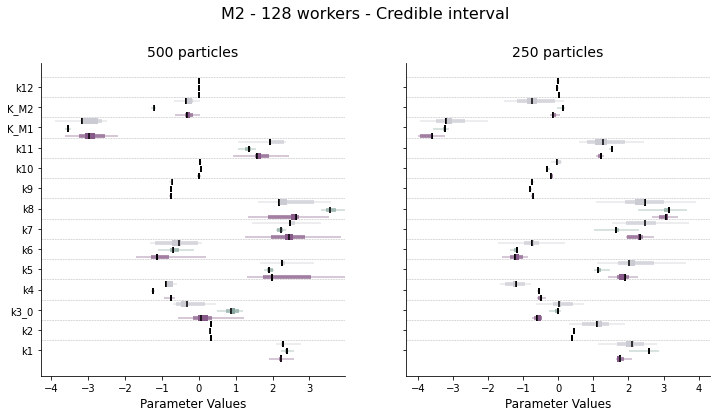

In [23]:
worker_size = 128


sampler_labels_set1 = ["liver_500_128", "liver_500_128_ORI", "liver_500_128_la_pre"]
sampler_labels_set2 = ["liver_250_128", "liver_250_128_ORI", "liver_250_128_la_pre"]



population_index = {"liver_500_128_1": 18, "liver_500_128_2": 10,
                    "liver_500_128_ORI_1": 26, "liver_500_128_ORI_2": 11,
                    "liver_500_128_la_pre_1": 20,"liver_500_128_la_pre_2": 12,
                   "liver_250_128_1": 10, "liver_250_128_2": 9, 
                    "liver_250_128_ORI_1": 25, "liver_250_128_ORI_2": 7,
                    "liver_250_128_la_pre_1": 25,"liver_250_128_la_pre_2": 15,
}

parameter_names=["k1", "k2", "k3_0", "k4",
                "k5", "k6", "k7", "k8",
                "k9", "k10", "k11", "K_M1",
                "K_M2", "intensity_normalization_total"
]


names={"k1": "Max. flux of SENSOR activation", "k2": "Max. flux of SENSOR inactivation",
                "k3_0": "Factor of YAP synthesis rate", "k4": "YAP inactivation rate",
                "k5": "YAP activation rate", "k6": "Inact YAP binding rate to SF",
                "k7": "Inact YAP unbin. rate from SF", "k8": "YAP export rate from nucleus",
                "k9": "YAP import rate into nucleus", "k10": "YAP degradation rate",
                "k11": "Inact YAP degradation rate", "K_M1": "M-M const. of SENSOR activation",
                "K_M2": "Max. flux of SENSOR inactivation",
                "intensity_normalization_total": "Intensity normalization total"}

names={"k1": "k1",
       "k2": "k2",
       "k3_0": "k3_0",
       "k4": "k4",
        "k5": "k5",
       "k6": "k6",
       "k7": "k7",
       "k8": "k8",
        "k9": "k9",
       "k10": "k10",
       "k11": "k11",
       "K_M1": "K_M1",
       "K_M2": "K_M2",
       "intensity_normalization_total": "k12"
}


iters = 1
levels = [0.1,0.5,0.99]
fig, ax = plt.subplots(1,2,figsize=(12,6))
offset = 0.3
for sampler_index, sampler_label in enumerate(sampler_labels_set1):
    times_for_sampler = []
    samples_for_sampler = []
    for ix in range(iters):
        sampler_db = f"{sampler_label}_{str(ix+1)}"
        pop_index = population_index[f"{sampler_label}_{str(ix+1)}"]

        h = pyabc.History(
            f"sqlite:///{gp}/{sampler_db}.db", create=False)
        median, cis = get_intervals(h, par_names=parameter_names, levels=levels, t_curr=pop_index-1)
#         median14, cis14 = get_intervals(history714, par_names=parameter_names, levels=levels, t_curr=13)

        plot_intervals(median, cis, par_names=parameter_names, ax=ax[0], levels=levels, offset=offset, color=colors_map_eps[sampler_label], alpha=1)
#         plot_intervals(median14, cis14, par_names=parameter_names, levels=levels, offset=-0.15, color = sim_color14)

        ax[0].set_yticks(range(len(parameter_names)))
        ax[0].set_yticklabels([names[parameter_names[i]] for i in range(len(parameter_names))], rotation=0)
        ax[0].set_xlabel("Parameter Values", fontsize=12)
        ax[0].spines['top'].set_visible(False)
        ax[0].spines['right'].set_visible(False)

        for i_c, confidence in reversed(list(enumerate(levels))):
            ax[0].hlines(0,0,0,
                      linewidth=10/len(levels)*(len(levels)-i_c),
                      alpha = 1/len(levels)*(len(levels)-i_c),
                      color="black",
                      label=str(int(100*confidence))+"% Quantile")

        ax[0].hlines(0,0,0, linewidth=10, alpha=1)
#         ax.hlines(0,0,0, linewidth=10, alpha=1, color=sim_color, label="7 param L1+Ada.+MAD+SensiLR+Manual - 32 nodes")
        #ax.vlines(0,0,0, color="black", label="Medians")

#         ax[0].legend(loc=1)
        offset = offset-0.35

offset = 0.3
levels = [0.1,0.5,0.99]

for sampler_index, sampler_label in enumerate(sampler_labels_set2):
    times_for_sampler = []
    samples_for_sampler = []
    for ix in range(iters):
        sampler_db = f"{sampler_label}_{str(ix+1)}"
        pop_index = population_index[f"{sampler_label}_{str(ix+1)}"]

        h = pyabc.History(
            f"sqlite:///{gp}/{sampler_db}.db", create=False)
        median, cis = get_intervals(h, par_names=parameter_names, levels=levels, t_curr=pop_index-1)
#         median14, cis14 = get_intervals(history714, par_names=parameter_names, levels=levels, t_curr=13)

        plot_intervals(median, cis, par_names=parameter_names, ax=ax[1], levels=levels, offset=offset, color=colors_map_eps[sampler_label], alpha=1)
#         plot_intervals(median14, cis14, par_names=parameter_names, levels=levels, offset=-0.15, color = sim_color14)

        ax[1].set_yticks(range(len(parameter_names)))
        ax[1].set_yticklabels("")
        ax[1].set_xlabel("Parameter Values", fontsize=12)
        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)

        for i_c, confidence in reversed(list(enumerate(levels))):
            ax[1].hlines(0,0,0,
                      linewidth=10/len(levels)*(len(levels)-i_c),
                      alpha = 1/len(levels)*(len(levels)-i_c),
                      color="black",
                      label=str(int(100*confidence))+"% Quantile")

        ax[1].hlines(0,0,0, linewidth=10, alpha=1)
#         ax.hlines(0,0,0, linewidth=10, alpha=1, color=sim_color, label="7 param L1+Ada.+MAD+SensiLR+Manual - 32 nodes")
        #ax.vlines(0,0,0, color="black", label="Medians")

#         ax[0].legend(loc=1)
        offset = offset-0.35

ax[0].set_title("500 particles", fontsize=14)
ax[1].set_title("250 particles", fontsize=14)


fig.suptitle(f"M2 - {worker_size} workers - Credible interval", fontsize=16)
fig.subplots_adjust(top=0.85)

plt.savefig(f"M2_figures/M2_1800_CI_500_250px{worker_size}w.pdf", format="pdf", bbox_inches="tight")


## Posterior Distribution

In [24]:
#specify which run to use
psize=1000
wsize=256
version=1


history_DLA_LA=pyabc.History("sqlite:///" +
                          os.path.join(gp,
                                       "Liver_"+str(psize)+"_"+str(wsize)+"_"+str(version)+".db"))
history_DLA=pyabc.History("sqlite:///" +
                          os.path.join(gp,
                                       "Liver_"+str(psize)+"_"+str(wsize)+"_la_pre_"+str(version)+".db"))

history_ORI=pyabc.History("sqlite:///" +
                          os.path.join(gp,
                                       "Liver_"+str(psize)+"_"+str(wsize)+"_ORI_"+str(version)+".db"))

history_DLA_LA.get_all_populations().to_csv("Tumor"+str(psize)+"AllPopLACurr.csv")
history_DLA.get_all_populations().to_csv("Tumor"+str(psize)+"AllPopLAPre.csv")
history_ORI.get_all_populations().to_csv("Tumor"+str(psize)+"AllPopOri.csv")

In [25]:
#set limits, parameter names, axis names

parameter_names=["k1", "k2", "k3_0", "k4",
                "k5", "k6", "k7", "k8",
                "k9", "k10", "k11", "K_M1",
                "K_M2", "intensity_normalization_total"
]


names={"k1": "Max. flux of SENSOR activation", "k2": "Max. flux of SENSOR inactivation",
                "k3_0": "Factor of YAP synthesis rate", "k4": "YAP inactivation rate",
                "k5": "YAP activation rate", "k6": "Inact YAP binding rate to SF",
                "k7": "Inact YAP unbin. rate from SF", "k8": "YAP export rate from nucleus",
                "k9": "YAP import rate into nucleus", "k10": "YAP degradation rate",
                "k11": "Inact YAP degradation rate", "K_M1": "M-M const. of SENSOR activation",
                "K_M2": "Max. flux of SENSOR inactivation",
                "intensity_normalization_total": "Intensity normalization total"}

names={"k1": "k1",
       "k2": "k2",
       "k3_0": "k3_0",
       "k4": "k4",
        "k5": "k5",
       "k6": "k6",
       "k7": "k7",
       "k8": "k8",
        "k9": "k9",
       "k10": "k10",
       "k11": "k11",
       "K_M1": "K_M1",
       "K_M2": "K_M2",
       "intensity_normalization_total": "k12"
}

obs_pars = {'k1': 100,
            'k2': 2.02,
            'k3_0': 1.7,
            'k4': 0.11,
            'k5': 100,
            'k6': 0.18,
            'k7': 100,
            'k8': 100,
            'k9': 0.17,
            'k10': 1.1,
            'k11': 30,
            'K_M1': 0.0008,
            'K_M2': 0.25,
            'intensity_normalization_total': 1}
limits = {key: (math.log10((10**-1)*val), math.log10((10**1)*val)) for key, val in obs_pars.items()}

#set_2
limits["k1"] = (1, 3)
limits["k5"] = (1, 4)
limits["k7"] = (1, 4)
limits["k8"] = (1, 4)
limits["k2"] = (0,2)
limits["K_M1"] = (-4,-2)

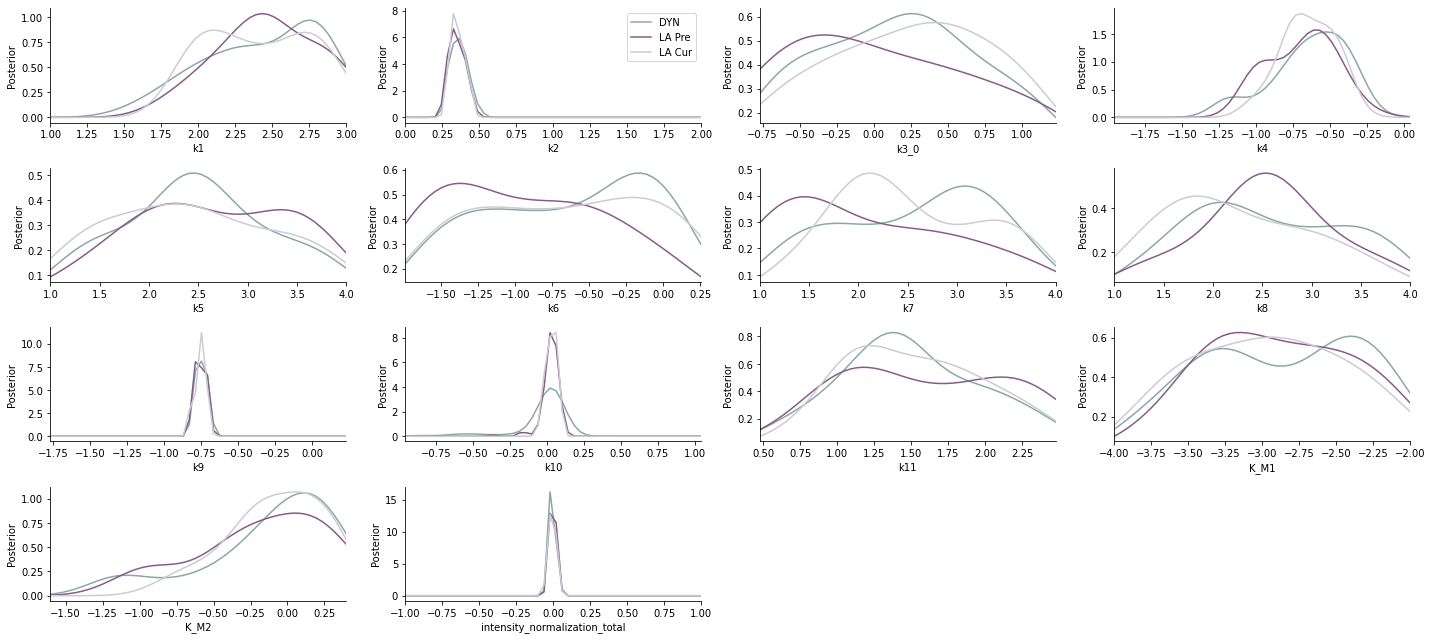

In [26]:
df, w = history_DLA.get_distribution(m=0, t=history_DLA.max_t)

df_LA, w_LA = history_DLA_LA.get_distribution(m=0, t=history_DLA_LA.max_t)

df_ORI, w_ORI = history_ORI.get_distribution(m=0, t=history_ORI.max_t)
fig, axes = plt.subplots(4,4, figsize=(20, 9))


for i, k in enumerate(parameter_names):
    if i <= 3:
        ax =axes[0,i]
    elif i > 3 and i <=7:
        ax =axes[1, i%4]
    elif i > 7 and i <=11:
        ax =axes[2, i%4]
    elif i > 11:
        ax =axes[3, i%4]
    pyabc.visualization.plot_kde_1d(df_ORI, w_ORI, k, xmin=limits[k][0], xmax=limits[k][1], c=samplers_color[0], ax=ax)
    pyabc.visualization.plot_kde_1d(df, w, k, xmin=limits[k][0], xmax=limits[k][1], c=samplers_color[1], ax=ax)
    pyabc.visualization.plot_kde_1d(df_LA, w_LA, k, xmin=limits[k][0], xmax=limits[k][1], c=samplers_color[2], ax=ax)

# remove additioal subplots
ax =axes[3,2]
ax.set_axis_off()
ax =axes[3,3]
ax.set_axis_off()
axes[0, 1].legend(['DYN', 'LA Pre', 'LA Cur'], loc='best')
# fig.suptitle("Liver model (M1)", fontsize=20)


fig.tight_layout()

plt.savefig("M2_figures/M2_1800_Posteriors"+str(psize)+"V"+str(version)+".pdf")
plt.show()

In [27]:
xticks = [0]
i=0
max_gen=max(len(history_DLA.get_all_populations()), len(history_ORI.get_all_populations()))-1

while i < max_gen-3:
    i=i+8
    xticks.append(i)


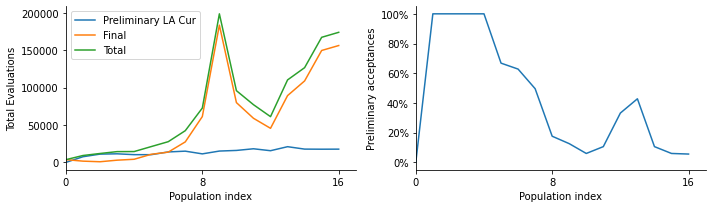

In [28]:
#Read .csv logfile of the run to extract the LA-mode statistics 
# Plot fraction of preliminary acceptances (Figure 19)
version=1
wsize=256
psize=1000

stat_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + "/Data/Model_M2/256_la_perturb_noise_v1/log"

stat_df = pd.read_csv(stat_path+"/Liver_regeneration_14para.csv")[1:]

fig, axes = plt.subplots(1,2, figsize=(10,3))


ax = axes[0]

ax.plot(stat_df['t'],stat_df['n_lookahead'], label="Preliminary LA Cur")
ax.plot(stat_df['t'],stat_df['n_evaluated']-stat_df['n_lookahead'], label="Final")
ax.plot(stat_df['t'],stat_df['n_evaluated'], label="Total")

ax.set_ylabel("Total Evaluations")
ax.set_xlim(xmin=0,xmax=len(stat_df))
ax.set_xlabel("Population index")
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.tick_params(axis='both', which='major', labelsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend()


ax = axes[1]

n_lookahead_particles=np.zeros(len(stat_df))
for i in range(len(stat_df)):
    n_lookahead_particles[i]=min(500, stat_df['n_lookahead_accepted'][i+1])/500
    
ax.plot(stat_df['t'], n_lookahead_particles)

ax.set_ylabel("Preliminary acceptances")
ax.set_xlim(xmin=0,xmax=len(stat_df))
ax.set_xlabel("Population index")
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)

from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=10)

fig.tight_layout()
plt.show()

fig.savefig("M2_figures/M2_1800_AcceptancesN"+str(psize)+"V"+str(version)+"_LA.pdf")

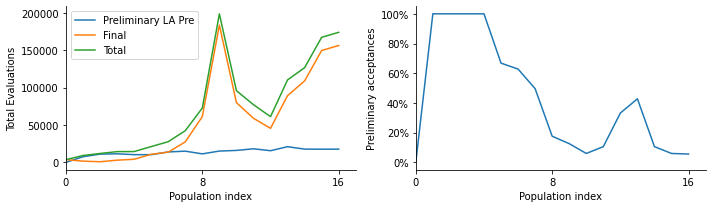

In [29]:
#Read .csv logfile of the run to extract the LA-mode statistics 
# Plot fraction of preliminary acceptances (Figure 19)
version=1
wsize=256
psize=1000

stat_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + "/Data/Model_M2/256_la_perturb_noise_v1/log"
stat_df = pd.read_csv(stat_path+"/Liver_regeneration_14para.csv")[1:]

fig, axes = plt.subplots(1,2, figsize=(10,3))


ax = axes[0]

ax.plot(stat_df['t'],stat_df['n_lookahead'], label="Preliminary LA Pre")
ax.plot(stat_df['t'],stat_df['n_evaluated']-stat_df['n_lookahead'], label="Final")
ax.plot(stat_df['t'],stat_df['n_evaluated'], label="Total")

ax.set_ylabel("Total Evaluations")
ax.set_xlim(xmin=0,xmax=len(stat_df))
ax.set_xlabel("Population index")
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.tick_params(axis='both', which='major', labelsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend()


ax = axes[1]

n_lookahead_particles=np.zeros(len(stat_df))
for i in range(len(stat_df)):
    n_lookahead_particles[i]=min(500, stat_df['n_lookahead_accepted'][i+1])/500
    
ax.plot(stat_df['t'], n_lookahead_particles)

ax.set_ylabel("Preliminary acceptances")
ax.set_xlim(xmin=0,xmax=len(stat_df))
ax.set_xlabel("Population index")
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)

from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=10)

fig.tight_layout()
plt.show()

fig.savefig("M2_figures/M2_1800_AcceptancesN"+str(psize)+"V"+str(version)+".pdf")

## Fitting plot of simulation to data

In [30]:

t_curr = 12
def get_intervals(history, par_names: List = None, levels: List = [0.5,0.95]):
    if par_names is None:
        # extract all parameter names
        df, _ = history.get_distribution(m=0)
        par_names = list(df.columns.values)
    
    median = np.empty((len(par_names)))
    cis = np.empty((len(par_names),2*len(levels)))
    
    df, w = history.get_distribution(m=0, t=t_curr)
    # normalize weights to be sure
    w /= w.sum()
    
    for i_par, par in enumerate(par_names):
        # as numpy array
        vals = np.array(df[par])
        # median
        median[i_par] = compute_quantile(vals, w, 0.5)
        # levels
        for i_c, confidence in enumerate(levels):
            lb, ub = compute_credible_interval(
                vals, w, confidence)
            cis[i_par, i_c] = lb
            cis[i_par, -1 - i_c] = ub
    return median, cis

def plot_intervals(median, cis,
                   par_names: List = None,
                   levels: List = [0.5,0.95],
                   offset: float=0,
                   color_code: str = None):
    if par_names is None:
        # extract all parameter names
        df, _ = history.get_distribution(m=0)
        par_names = list(df.columns.values)

    for i_par, par in enumerate(par_names):
        for i_c, confidence in reversed(list(enumerate(levels))):
            ax.hlines(i_par+offset,
                      cis[i_par, i_c],
                      cis[i_par, -1 - i_c],
                      linewidth=10/len(levels)*(len(levels)-i_c),
                      alpha = 1/len(levels)*(len(levels)-i_c),
                      color=color_code)
            ax.vlines(median[i_par],offset+i_par-0.2,offset+i_par+0.2, color="black")
    xmin,xmax=ax.get_xlim()
    for i_par, par in enumerate(par_names):
        ax.hlines(i_par+0.5,xmin, xmax, color="black", linewidth=1, linestyle="dashed", alpha=0.3)
    ax.set_xlim(xmin,xmax)        
    

def plot_intervals_ax(median, cis,
                   par_names: List = None,
                   levels: List = [0.5,0.95],
                   offset: float=0,
                   color_code: str = None,
                   ax = None):
    if par_names is None:
        # extract all parameter names
        df, _ = history.get_distribution(m=0)
        par_names = list(df.columns.values)

    for i_par, par in enumerate(par_names):
        for i_c, confidence in reversed(list(enumerate(levels))):
            ax.hlines(i_par+offset,
                      cis[i_par, i_c],
                      cis[i_par, -1 - i_c],
                      linewidth=10/len(levels)*(len(levels)-i_c),
                      alpha = 1/len(levels)*(len(levels)-i_c),
                      color=color_code)
            ax.vlines(median[i_par],offset+i_par-0.2,offset+i_par+0.2, color="black")
    xmin,xmax=ax.get_xlim()
    for i_par, par in enumerate(par_names):
        ax.hlines(i_par+0.5,xmin, xmax, color="black", linewidth=1, linestyle="dashed", alpha=0.3)
    ax.set_xlim(xmin,xmax)        
def prepare_subset_of_sumstat(sim, time_points, step):
    new_dict = dict()
    for key in [*sim]:
        if key == 'loc':
            continue
        new_dict[key] = []
        for index in time_points:
            new_dict[key].extend(sim[key][index * step:(index * step) + step])
    for key, val in new_dict.items():
        new_dict[key] = np.array(val)
    return new_dict


class FittingVis:
    """
    Fitting plots for fitmulticell pipeline.
    """

    def __init__(self,
                 history: pyabc.History,
                 obs_ss: dict,
                 obs_ss_err: dict,
                 cell_types_list: list = None,
                 sumstat_name_separator: str = "_",
                 adjustment=None
                 ):

        self.history = history
        self.obs_ss = obs_ss
        self.obs_ss_err = obs_ss_err
        self.cell_types_list = cell_types_list
        self.sumstat_name_separator = sumstat_name_separator
        self.adjustment = adjustment


    def plot_fitting(self, sumstat_func_name,
                     x_values,
                     ax: mpl.axes.Axes = None,
                     fig = None,
                     title="fitting plot",
                     title_fontsize=16,
                     population_index=None,
                     subtitle=None,
                     subtitle_fontsize=7,
                     x_y_fontsize=12,
                     xticks=[],
                     s_color="lightsteelblue",
                     m_color="royalblue",
                     s_label="Simulation",
                     m_label="measurement",
                     x_label='x axis',
                     y_label='y axis',
                     fig_size=None,
                     set_ylimit=None,
                     linewidth=1.0,
                     measurement_marker="x",
                     group_by=1,
                     alpha=1,
                     obs_flag=True,
                     legend_flag=True,
                     row_fig=0,
                     particles=None
                     ):
        first_flag = True
        if not population_index:
            population = self.history.get_population()
        else:
            population = self.history.get_population(population_index)
        if len(xticks) == 0:
            xticks = x_values
        if particles is None:
            particles = population._list.__len__()
        rows, cols = 2, 6
        if ax is None:
            fig, ax = plt.subplots(rows, cols,
                               sharex='col',
                               sharey='row')

        nr_rows = self.obs_ss.shape[1]
        fig.suptitle(title, fontsize=title_fontsize)
        for j in range(particles):
            curr_particle = population.particles[j].sum_stat
            unique_obs = [0, 8, 15, 20, 30, 50]
            curr_particle_2 = curr_particle
            if not isinstance(
                    [v for k, v in curr_particle_2.items() if
                     sumstat_func_name in k][0],
                    int):
                q = [v for k, v in curr_particle_2.items() if
                     sumstat_func_name in k]
                for [i, v], index in zip(enumerate(range(nr_rows)),
                                         range(0, len(q[0]), group_by)):
                    # row = (0 if v <3 else 1)
                    row = row_fig
                    col = v % 6
                    simulation_result = q[0][index:index+group_by]
                    if len(simulation_result) == 1:
                        simulation_result = simulation_result[0]
                    if j == particles-1 and legend_flag:
                        ax[row, col].plot(x_values, simulation_result, c=s_color, alpha=alpha,label=s_label,zorder=0)
                    else:
                        ax[row, col].plot(x_values, simulation_result, c=s_color, alpha=alpha,zorder=0)
                    if (j == particles-1 and obs_flag) == True:
                        ax[row, col].errorbar(x_values, self.obs_ss[:, i],fmt='.k',yerr=self.obs_ss_err[:, i],zorder=10, label=m_label)
                    if row == 1:
                        ax[row, col].set_xlabel(x_label)
                    if col == 0:
                        ax[row, col].set_ylabel(y_label)

                    ax[row, col].set_xticks(xticks)
                    ax[row, col].set_ylim(set_ylimit)
                    ax[row, col].set_title("t="+str(unique_obs[v]/10)+"d")
        if legend_flag:
            ax[0, 0].legend(loc='best')
        fig.set_figheight(fig_size[0])
        fig.set_figwidth(fig_size[1])

        return ax, fig



def computee_credible_interval(vals, confidence: float = 0.95):
    """
    Compute credible interval to confidence level `confidence` for points
    `vals` associated to weights `weights`.
    Returns
    -------
    lb, ub: tuple of float
        Lower and upper bound of the credible interval.
    """
    if confidence <= 0.0 or confidence >= 1.0:
        raise ValueError(
            f"Confidence {confidence} must be in the interval (0.0, 1.0)."
        )
    alpha_lb = 0.5 * (1.0 - confidence)
    alpha_ub = confidence + alpha_lb
    lb = weighted_quantile(vals, alpha=alpha_lb)
    ub = weighted_quantile(vals, alpha=alpha_ub)
    return lb, ub

class FittingVis_interval:
    """
    Fitting plots for fitmulticell pipeline.
    """

    def __init__(self,
                 history: pyabc.History,
                 obs_ss: dict,
                 obs_ss_err: dict,
                 cell_types_list: list = None,
                 sumstat_name_separator: str = "_",
                 adjustment=None
                 ):

        self.history = history
        self.obs_ss = obs_ss
        self.obs_ss_err = obs_ss_err
        self.cell_types_list = cell_types_list
        self.sumstat_name_separator = sumstat_name_separator
        self.adjustment = adjustment


    def plot_fitting_interval(self, sumstat_func_name,
                     x_values,
                     ax: mpl.axes.Axes = None,
                     fig = None,
                     title = None,
                     title_fontsize=16,
                     population_index=None,
                     subtitle=None,
                     subtitle_fontsize=7,
                     x_y_fontsize=12,
                     xticks=[],
                     mean_color="lightsteelblue",
                     std_color = "lightsteelblue",
                     m_color="royalblue",
                     s_label="Sim",
                     m_label="Obs",
                     x_label='x axis',
                     y_label='y axis',
                     fig_size=None,
                     set_ylimit=None,
                     linewidth=1.0,
                     measurement_marker="x",
                     group_by=1,
                     std_alpha=1,
                     obs_flag=True,
                     legend_flag=True,
                     row_fig=0,
                     particles=None,
                     confidence=0.95,
                     mean_flag = True
                     ):
        first_flag = True
        if not population_index:
            population = self.history.get_population()
        else:
            population = self.history.get_population(population_index)
        if len(xticks) == 0:
            xticks = x_values
        if particles is None:
            particles = population._list.__len__()
        rows, cols = 2, 6
        if ax is None:
            fig, ax = plt.subplots(rows, cols,
                               sharex='col',
                               sharey='row')

        nr_rows = self.obs_ss.shape[1]
        fig.suptitle(title, fontsize=title_fontsize)
        all_particles={}
        for j in range(particles):
            curr_particle = population.particles[j].sum_stat
            unique_obs = [0, 8, 15, 20, 30, 50]
            curr_particle_2 = curr_particle
            if not isinstance(
                    [v for k, v in curr_particle_2.items() if
                     sumstat_func_name in k][0],
                    int):
                q = [v for k, v in curr_particle_2.items() if
                     sumstat_func_name in k]
                for [i, v], index in zip(enumerate(range(nr_rows)),
                                         range(0, len(q[0]), group_by)):
                    # row = (0 if v <3 else 1)
                    row = row_fig
                    col = v % 6
                    simulation_result = q[0][index:index+group_by]
                    if j == 0:
                        all_particles[str(row+col)]=[]
                    all_particles[str(row+col)].append(simulation_result)
                    if j == particles-1:
#                         means = np.mean(all_particles[str(row+col)], axis=0)
#                         stds = np.std(all_particles[str(row+col)], axis=0)
                        susmstat_m = []
                        susmstat_lb = []
                        susmstat_ub = []
                        for jj in range(10):
                            elemnts = [item[jj] for item in all_particles[str(row+col)]]
                            elemnts = np.array(elemnts)

                            susmstat_m.append(weighted_quantile(elemnts, alpha=0.50))
                            lb, ub = computee_credible_interval(elemnts, confidence=confidence)
                            susmstat_lb.append(lb)
                            susmstat_ub.append(ub)
#                         ax[row, col].fill_between(x_values, means-stds,means+stds,alpha=std_alpha,color=mean_color)
                        ax[row, col].fill_between(x_values, susmstat_lb,susmstat_ub,alpha=std_alpha,color=std_color, label=s_label)
                        if mean_flag:
                            ax[row, col].plot(x_values, susmstat_m, c=mean_color, label="T15 mean")

                    if (j == particles-1 and obs_flag) == True:
                        ax[row, col].errorbar(x_values, self.obs_ss[:, i],fmt='o',markersize=4, color=m_color,yerr=self.obs_ss_err[:, i]*3,zorder=10, label=m_label)
#                         ax[row, col].errorbar(x_values, self.obs_ss[:, i],fmt='.'+m_color,yerr=self.obs_ss_err[:, i],zorder=10, label=m_label)

#                     if row == 1:
#                         ax[row, col].set_xlabel(x_label, fontsize=x_y_fontsize)
                    if col == 0:
                        ax[row, col].set_ylabel(y_label, fontsize=x_y_fontsize)

                    ax[row, col].set_xticks(xticks, fontsize=20)
                    ax[row, col].set_ylim(set_ylimit)
                    if row == 0:
                        ax[row, col].set_title("t="+str(unique_obs[v]/10)+"d")
#                     ax[row, col].xaxis.set_tick_params(labelsize=x_y_fontsize)
                    ax[row, col].set_xticks([1,5,10])
                    ax[row, col].yaxis.set_tick_params(labelsize=x_y_fontsize)
                    ax[row, col].xaxis.set_tick_params(labelsize=x_y_fontsize)
#                     plt.gca().xaxis.set_major_locator(plt.MaxNLocator(2))



    #         all_particles.append(population.particles[j].sum_stat)

#                     ax[row, col].set_xticks(xticks)
#                     ax[row, col].set_ylim(set_ylimit)
#                     ax[row, col].set_title("t="+str(unique_obs[v]/10)+"d")
        if title:
            fig.suptitle(title)
        if legend_flag:
            ax[0, 0].legend(loc='best', fontsize=11)
        fig.set_figheight(fig_size[0])
        fig.set_figwidth(fig_size[1])

        return ax, fig



In [31]:
#specify which run to use
psize=1000
wsize=256
version=1

history_DLA_LA=pyabc.History("sqlite:///" +
                          os.path.join(gp,
                                       "Liver_"+str(psize)+"_"+str(wsize)+"_"+str(version)+".db"))
history_DLA=pyabc.History("sqlite:///" +
                          os.path.join(gp,
                                       "Liver_"+str(psize)+"_"+str(wsize)+"_la_pre_"+str(version)+".db"))

history_ORI=pyabc.History("sqlite:///" +
                          os.path.join(gp,
                                       "Liver_"+str(psize)+"_"+str(wsize)+"_ORI_"+str(version)+".db"))


CI_size = (7.5,7.5)
fit_size = (8, 12)


obs_color = "blue"

# x_label = "Time (h)"
x = np.arange(1, 11)
xx = np.arange(0, 144, step=12)
# obs_data = load_obj("obs_data_4_132t")
# path_figure = "/home/emad/Insync/blackhand.3@gmail.com/Google_Drive/Bonn/Documents/FitMultiCell/liver_regeneration/5_parameters/fitting/"
subtitles=["time 0.0", "time 0.8", "time 1.5", "time 2.0", "time 3.0", "time 5.0"]

# obs = '/home/emad/Insync/blackhand.3@gmail.com/Google_Drive/Bonn/Documents/Morpheus/Liver_regeneration/YAP_Signaling_Liver_Regeneration_Data_edited_6.csv'
# my_data = genfromtxt(obs, delimiter=',')
# N_YAP_obs = my_data[1:11,0:6]
# N_YAP_obs_err = my_data[1:11,6:12]

# total_YAP_obs =  my_data[1:11,12:18]
# total_YAP_obs_err =  my_data[1:11,18:24]

# adj = {"left":0.125, "bottom":0.062, "right":0.90, "top":0.88, "wspace":0.2,"hspace":0.634}
sumstat_func = ["YAP_nuclear_observable", "YAP_total_observable"]
color_DYN= ['#e6e6ff','#b3b3ff','#8080ff', '#4d4dff','#0000ff']
color_la = ['#fff5e6', '#ffe0b3','#ffcc80','#ffad33','#e68a00']
color = color_DYN
# sumstat= sumstat_func[1]
# y_label = "Nuclear YAP concentration"
# particles = 1000


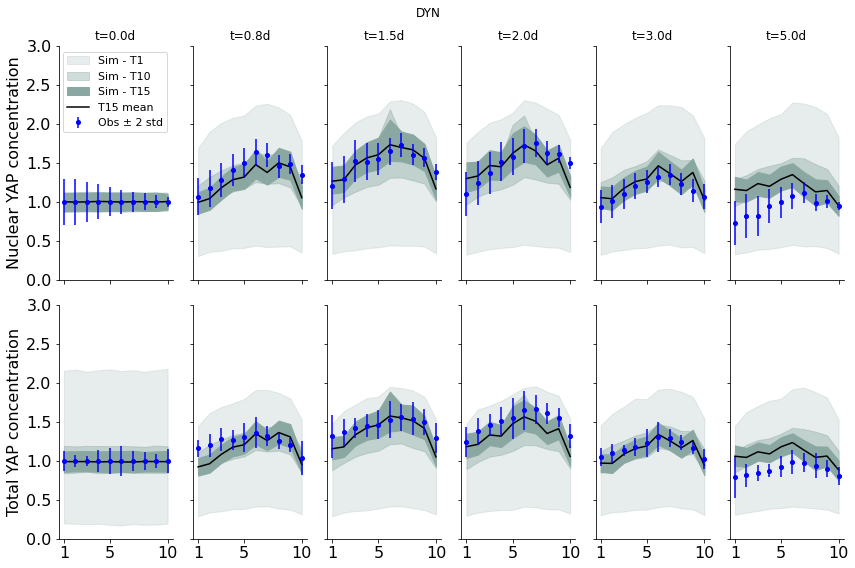

In [34]:
sim_color = samplers_color[0]
sumstat= sumstat_func[0]
y_label = "Nuclear YAP concentration"
color_t12 = sim_color
color_t1 = sim_color
color_std = sim_color
history = history_ORI
alpha_std = 0.2


obs = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + "/Data/Model_M2/obs_data/YAP_Signaling_Liver_Regeneration_Data_edited_6.csv"
my_data = genfromtxt(obs, delimiter=',')
N_YAP_obs = my_data[1:11,0:6]
N_YAP_obs_err = my_data[1:11,6:12]

total_YAP_obs =  my_data[1:11,12:18]
total_YAP_obs_err =  my_data[1:11,18:24]

adj = {"left":0.125, "bottom":0.062, "right":0.90, "top":0.88, "wspace":0.2,"hspace":0.634}

x_label = "Time (h)"
x = np.arange(1, 11)
xx = np.arange(0, 144, step=12)
# obs_data = load_obj("obs_data_4_132t")
sumstat_func = ["YAP_nuclear_observable", "YAP_total_observable"]
subtitles=["time 0.0", "time 0.8", "time 1.5", "time 2.0", "time 3.0", "time 5.0"]
particles = 1000
confidence=0.95
font_size = 15


vis = FittingVis_interval(history, obs_ss=N_YAP_obs,obs_ss_err=N_YAP_obs_err, adjustment=adj)

ax1, fig1 = FittingVis_interval.plot_fitting_interval(vis, sumstat, obs_flag=False, legend_flag=False, mean_flag=False,
                                    population_index=1, s_label= "Sim - T1" ,mean_color=color_t1,
                                    std_color = color_std, m_color=obs_color,title=" ", title_fontsize=16,
                                    x_values=x, x_label="CV-PV axis zone", y_label=y_label,
                                    subtitle=copy.deepcopy(subtitles), fig_size=fit_size,group_by=10, 
                                    set_ylimit=[0,3], row_fig=0, particles=particles, std_alpha=0.2, x_y_fontsize=16)

ax2, fig2 = FittingVis_interval.plot_fitting_interval(vis, sumstat, obs_flag=False, legend_flag=False, mean_flag=False, population_index=10, ax=ax1, fig=fig1,
                                    s_label= "Sim - T10" ,mean_color=obs_color, std_color = color_std, m_color=obs_color,title=" ", title_fontsize=16,
                                    x_values=x, x_label="CV-PV axis zone", y_label=y_label,subtitle=copy.deepcopy(subtitles),
                                    fig_size=fit_size,group_by=10,set_ylimit=[0,3], row_fig=0, particles=particles, std_alpha=0.40,
                                                      x_y_fontsize=16)


ax3, fig3 = FittingVis_interval.plot_fitting_interval(vis, sumstat, obs_flag=True, legend_flag=True, mean_flag=True, population_index=15, ax=ax2, fig=fig2,
                                    s_label= "Sim - T15" ,m_label= "Obs " u"\u00B1" " 2 std", mean_color="k", std_color = color_std, m_color=obs_color,title=" ", title_fontsize=12,
                                    x_values=x, x_label="CV-PV axis zone", y_label=y_label,subtitle=copy.deepcopy(subtitles),
                                    fig_size=fit_size,group_by=10,set_ylimit=[0,3], row_fig=0, particles=particles, std_alpha=1,
                                                      x_y_fontsize=16)


sumstat= sumstat_func[1]
y_label = "Total YAP concentration"
vis = FittingVis_interval(history, obs_ss=total_YAP_obs,obs_ss_err=total_YAP_obs_err, adjustment=adj)

ax4, fig4 = FittingVis_interval.plot_fitting_interval(vis, sumstat, obs_flag=False, legend_flag=False, mean_flag=False, ax=ax3, fig=fig3, 
                                    population_index=1, s_label= "Sim - T1", mean_color=color_t1, std_color = color_std,
                                    m_color='C1',title=" ", title_fontsize=12, x_values=x, x_label="CV-PV axis zone",
                                    y_label=y_label,subtitle=copy.deepcopy(subtitles), fig_size=fit_size,
                                    group_by=10,set_ylimit=[0,3], row_fig=1, particles=particles, x_y_fontsize=16,
                                    std_alpha=0.20, )

ax5, fig5 = FittingVis_interval.plot_fitting_interval(vis, sumstat, obs_flag=False, legend_flag=False, mean_flag=False, ax=ax4, fig=fig4, 
                                    population_index=10, s_label= "Sim - T10", mean_color=obs_color, std_color = color_std,
                                    m_color=obs_color,title=" ", title_fontsize=12, x_values=x, x_label="CV-PV axis zone",
                                    y_label=y_label,subtitle=copy.deepcopy(subtitles), fig_size=fit_size,
                                    group_by=10,set_ylimit=[0,3], row_fig=1, particles=particles , x_y_fontsize=16,
                                    std_alpha=0.40)

ax6, fig6 = FittingVis_interval.plot_fitting_interval(vis, sumstat, obs_flag=True, legend_flag=False, ax=ax5, fig=fig5, 
                                    population_index=15, s_label= "Sim - T15", m_label= "Obs " u"\u00B1" " 2 std", mean_color="k", std_color = color_std,
                                    m_color=obs_color,title="DYN", title_fontsize=16, x_values=x, x_label="CV-PV axis zone",
                                    y_label=y_label,subtitle=copy.deepcopy(subtitles), fig_size=fit_size,
                                    group_by=10,set_ylimit=[0,3], row_fig=1, particles=particles , x_y_fontsize=16,
                                    std_alpha=1)


fig6.tight_layout()
# fig6.text(0.5, -0.01, 'CV-PV axis zone', ha='center', fontsize=font_size)

# plt.show()
plt.savefig("M2_figures/M2_fit_DYN.pdf", format="pdf")


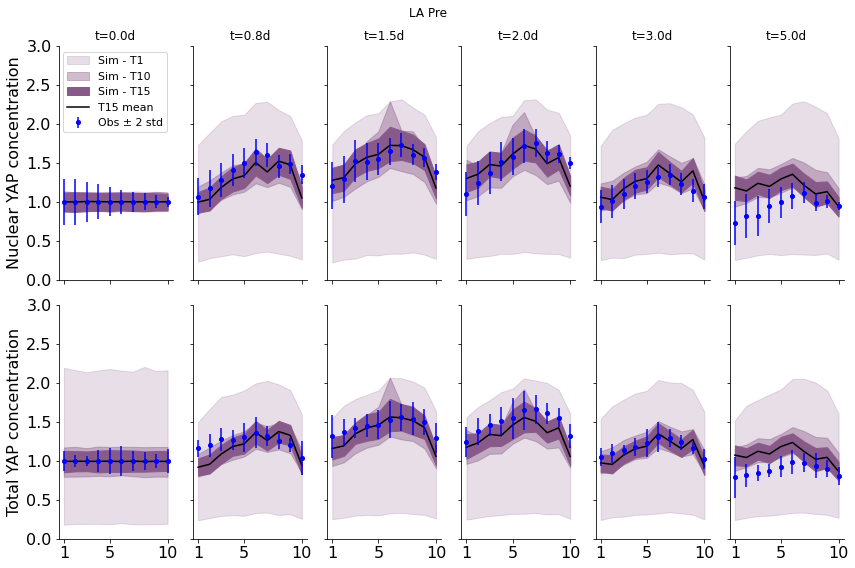

In [35]:
sim_color = samplers_color[1]
sumstat= sumstat_func[0]
y_label = "Nuclear YAP concentration"
color_t12 = sim_color
color_t1 = sim_color
color_std = sim_color
history = history_DLA
alpha_std = 0.2


vis = FittingVis_interval(history, obs_ss=N_YAP_obs,obs_ss_err=N_YAP_obs_err, adjustment=adj)

ax1, fig1 = FittingVis_interval.plot_fitting_interval(vis, sumstat, obs_flag=False, legend_flag=False, mean_flag=False,
                                    population_index=1, s_label= "Sim - T1" ,mean_color=color_t1,
                                    std_color = color_std, m_color=obs_color,title=" ", title_fontsize=12,
                                    x_values=x, x_label="CV-PV axis zone", y_label=y_label,
                                    subtitle=copy.deepcopy(subtitles), fig_size=fit_size,group_by=10, 
                                    set_ylimit=[0,3], row_fig=0, particles=particles, std_alpha=0.2, x_y_fontsize=16)

ax2, fig2 = FittingVis_interval.plot_fitting_interval(vis, sumstat, obs_flag=False, legend_flag=False, mean_flag=False, population_index=10, ax=ax1, fig=fig1,
                                    s_label= "Sim - T10" ,mean_color=obs_color, std_color = color_std, m_color=obs_color,title=" ", title_fontsize=12,
                                    x_values=x, x_label="CV-PV axis zone", y_label=y_label,subtitle=copy.deepcopy(subtitles),
                                    fig_size=fit_size,group_by=10,set_ylimit=[0,3], row_fig=0, particles=particles, std_alpha=0.40,
                                                      x_y_fontsize=16)


ax3, fig3 = FittingVis_interval.plot_fitting_interval(vis, sumstat, obs_flag=True, legend_flag=True, mean_flag=True, population_index=15, ax=ax2, fig=fig2,
                                    s_label= "Sim - T15" ,m_label= "Obs " u"\u00B1" " 2 std", mean_color="k", std_color = color_std, m_color=obs_color,title=" ", title_fontsize=12,
                                    x_values=x, x_label="CV-PV axis zone", y_label=y_label,subtitle=copy.deepcopy(subtitles),
                                    fig_size=fit_size,group_by=10,set_ylimit=[0,3], row_fig=0, particles=particles, std_alpha=1,
                                                      x_y_fontsize=16)


sumstat= sumstat_func[1]
y_label = "Total YAP concentration"
vis = FittingVis_interval(history, obs_ss=total_YAP_obs,obs_ss_err=total_YAP_obs_err, adjustment=adj)

ax4, fig4 = FittingVis_interval.plot_fitting_interval(vis, sumstat, obs_flag=False, legend_flag=False, mean_flag=False, ax=ax3, fig=fig3, 
                                    population_index=1, s_label= "Sim - T1", mean_color=color_t1, std_color = color_std,
                                    m_color='C1',title=" ", title_fontsize=12, x_values=x, x_label="CV-PV axis zone",
                                    y_label=y_label,subtitle=copy.deepcopy(subtitles), fig_size=fit_size,
                                    group_by=10,set_ylimit=[0,3], row_fig=1, particles=particles, x_y_fontsize=16,
                                    std_alpha=0.20, )

ax5, fig5 = FittingVis_interval.plot_fitting_interval(vis, sumstat, obs_flag=False, legend_flag=False, mean_flag=False, ax=ax4, fig=fig4, 
                                    population_index=10, s_label= "Sim - T10", mean_color=obs_color, std_color = color_std,
                                    m_color=obs_color,title=" ", title_fontsize=12, x_values=x, x_label="CV-PV axis zone",
                                    y_label=y_label,subtitle=copy.deepcopy(subtitles), fig_size=fit_size,
                                    group_by=10,set_ylimit=[0,3], row_fig=1, particles=particles , x_y_fontsize=16,
                                    std_alpha=0.40)

ax6, fig6 = FittingVis_interval.plot_fitting_interval(vis, sumstat, obs_flag=True, legend_flag=False, ax=ax5, fig=fig5, 
                                    population_index=15, s_label= "Sim - T15", m_label= "Obs " u"\u00B1" " 2 std", mean_color="k", std_color = color_std,
                                    m_color=obs_color,title="LA Pre", title_fontsize=16, x_values=x, x_label="CV-PV axis zone",
                                    y_label=y_label,subtitle=copy.deepcopy(subtitles), fig_size=fit_size,
                                    group_by=10,set_ylimit=[0,3], row_fig=1, particles=particles , x_y_fontsize=16,
                                    std_alpha=1)


fig6.tight_layout()
# fig6.text(0.5, -0.01, 'CV-PV axis zone', ha='center', fontsize=font_size)

# plt.show()
plt.savefig("M2_figures/M2_fit_LA_Pre.pdf", format="pdf")


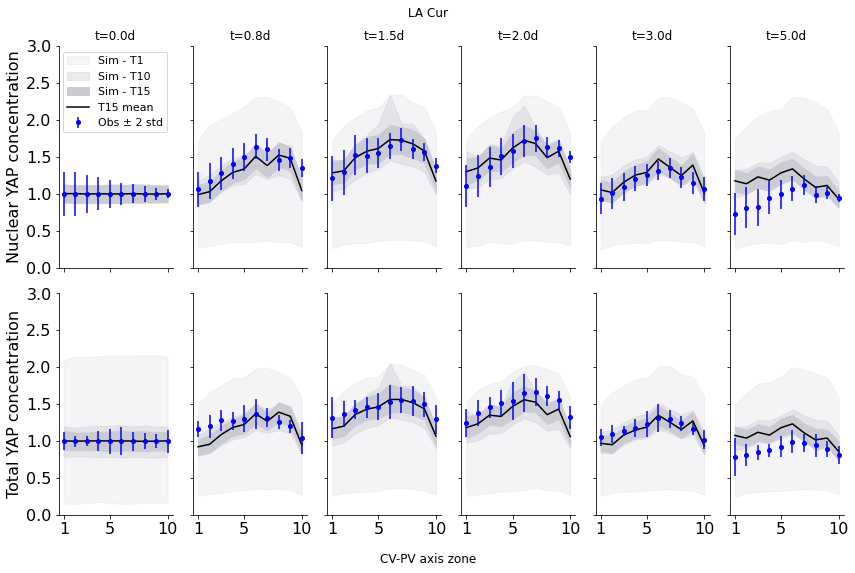

In [36]:
sim_color = samplers_color[2]
sumstat= sumstat_func[0]
y_label = "Nuclear YAP concentration"
color_t12 = sim_color
color_t1 = sim_color
color_std = sim_color
history = history_DLA_LA
alpha_std = 0.2


vis = FittingVis_interval(history, obs_ss=N_YAP_obs,obs_ss_err=N_YAP_obs_err, adjustment=adj)

ax1, fig1 = FittingVis_interval.plot_fitting_interval(vis, sumstat, obs_flag=False, legend_flag=False, mean_flag=False,
                                    population_index=1, s_label= "Sim - T1" ,mean_color=color_t1,
                                    std_color = color_std, m_color=obs_color,title=" ", title_fontsize=12,
                                    x_values=x, x_label="CV-PV axis zone", y_label=y_label,
                                    subtitle=copy.deepcopy(subtitles), fig_size=fit_size,group_by=10, 
                                    set_ylimit=[0,3], row_fig=0, particles=particles, std_alpha=0.2, x_y_fontsize=16)

ax2, fig2 = FittingVis_interval.plot_fitting_interval(vis, sumstat, obs_flag=False, legend_flag=False, mean_flag=False, population_index=10, ax=ax1, fig=fig1,
                                    s_label= "Sim - T10" ,mean_color=obs_color, std_color = color_std, m_color=obs_color,title=" ", title_fontsize=12,
                                    x_values=x, x_label="CV-PV axis zone", y_label=y_label,subtitle=copy.deepcopy(subtitles),
                                    fig_size=fit_size,group_by=10,set_ylimit=[0,3], row_fig=0, particles=particles, std_alpha=0.40,
                                                      x_y_fontsize=16)


ax3, fig3 = FittingVis_interval.plot_fitting_interval(vis, sumstat, obs_flag=True, legend_flag=True, mean_flag=True, population_index=15, ax=ax2, fig=fig2,
                                    s_label= "Sim - T15" ,m_label= "Obs " u"\u00B1" " 2 std", mean_color="k", std_color = color_std, m_color=obs_color,title=" ", title_fontsize=12,
                                    x_values=x, x_label="CV-PV axis zone", y_label=y_label,subtitle=copy.deepcopy(subtitles),
                                    fig_size=fit_size,group_by=10,set_ylimit=[0,3], row_fig=0, particles=particles, std_alpha=1,
                                                      x_y_fontsize=16)


sumstat= sumstat_func[1]
y_label = "Total YAP concentration"
vis = FittingVis_interval(history, obs_ss=total_YAP_obs,obs_ss_err=total_YAP_obs_err, adjustment=adj)

ax4, fig4 = FittingVis_interval.plot_fitting_interval(vis, sumstat, obs_flag=False, legend_flag=False, mean_flag=False, ax=ax3, fig=fig3, 
                                    population_index=1, s_label= "Sim - T1", mean_color=color_t1, std_color = color_std,
                                    m_color='C1',title=" ", title_fontsize=12, x_values=x, x_label="CV-PV axis zone",
                                    y_label=y_label,subtitle=copy.deepcopy(subtitles), fig_size=fit_size,
                                    group_by=10,set_ylimit=[0,3], row_fig=1, particles=particles, x_y_fontsize=16,
                                    std_alpha=0.20, )

ax5, fig5 = FittingVis_interval.plot_fitting_interval(vis, sumstat, obs_flag=False, legend_flag=False, mean_flag=False, ax=ax4, fig=fig4, 
                                    population_index=10, s_label= "Sim - T10", mean_color=obs_color, std_color = color_std,
                                    m_color=obs_color,title=" ", title_fontsize=12, x_values=x, x_label="CV-PV axis zone",
                                    y_label=y_label,subtitle=copy.deepcopy(subtitles), fig_size=fit_size,
                                    group_by=10,set_ylimit=[0,3], row_fig=1, particles=particles , x_y_fontsize=16,
                                    std_alpha=0.40)

ax6, fig6 = FittingVis_interval.plot_fitting_interval(vis, sumstat, obs_flag=True, legend_flag=False, ax=ax5, fig=fig5, 
                                    population_index=15, s_label= "Sim - T15", m_label= "Obs " u"\u00B1" " 2 std", mean_color="k", std_color = color_std,
                                    m_color=obs_color,title="LA Cur", title_fontsize=16, x_values=x, x_label="CV-PV axis zone",
                                    y_label=y_label,subtitle=copy.deepcopy(subtitles), fig_size=fit_size,
                                    group_by=10,set_ylimit=[0,3], row_fig=1, particles=particles , x_y_fontsize=16,
                                    std_alpha=1)


# fig6.tight_layout()
# fig6.text(0.5, -0.01, 'CV-PV axis zone', ha='center', fontsize=font_size)
fig6.supxlabel('CV-PV axis zone')
plt.tight_layout()
# plt.show()
plt.savefig("M2_figures/M2_fit_LA.pdf", format="pdf")


In [37]:

population_index = {"liver_1000_256_1": 15, "liver_1000_256_2": 15,
                    "liver_1000_256_ORI_1": 16, "liver_1000_256_ORI_2": 16,
                    "liver_1000_256_la_pre_1": 15,"liver_1000_256_la_pre_2": 15,
                   "liver_500_256_1": 16, "liver_500_256_2": 14, 
                    "liver_500_256_ORI_1": 14, "liver_500_256_ORI_2": 18,
                    "liver_500_256_la_pre_1": 14,"liver_500_256_la_pre_2": 12,
                    "liver_500_128_1": 14, "liver_500_128_2": 16,
                    "liver_500_128_ORI_1": 18, "liver_500_128_ORI_2": 15,
                    "liver_500_128_la_pre_1": 15,"liver_500_128_la_pre_2": 14,
                   "liver_250_128_1": 16, "liver_250_128_2": 17, 
                    "liver_250_128_ORI_1": 18, "liver_250_128_ORI_2": 18,
                    "liver_250_128_la_pre_1": 18,"liver_250_128_la_pre_2": 14,

}


## Epsilon Vs. Time

In [39]:
#specify which run to use
psize=500
wsize=128
version=2

#read in database as pyabc.history object

history_DLA_LA=pyabc.History("sqlite:///" +
                          os.path.join(gp,
                                       "liver_"+str(psize)+"_"+str(wsize)+"_"+str(version)+".db"))
history_DLA=pyabc.History("sqlite:///" +
                          os.path.join(gp,
                                       "liver_"+str(psize)+"_"+str(wsize)+"_la_pre_"+str(version)+".db"))

history_ORI=pyabc.History("sqlite:///" +
                          os.path.join(gp,
                                       "liver_"+str(psize)+"_"+str(wsize)+"_ORI_"+str(version)+".db"))

# history_DLA_LA.get_all_populations().to_csv(gp+"/Tumor"+str(psize)+"AllPopLACurr.csv")
# history_DLA.get_all_populations().to_csv(gp+"/Tumor"+str(psize)+"AllPopLAPre.csv")
# history_ORI.get_all_populations().to_csv(gp+"/Tumor"+str(psize)+"AllPopOri.csv")
#Extract runtime information

DLADF = history_DLA.get_all_populations()
DLADF = DLADF.truncate(after=population_index[f"liver_{psize}_{wsize}_la_pre_{version}"])
print(population_index[f"liver_{psize}_{wsize}_la_pre_{version}"])
starttime = DLADF["population_end_time"][0]

new_col=[]
for i in range(0,len(DLADF)):
    new_col.append((DLADF["population_end_time"][i]-DLADF["population_end_time"][0]).total_seconds())

DLADF.insert(2, "time_passed_s", new_col, True)


ORIDF = history_ORI.get_all_populations()
ORIDF = ORIDF.truncate(after=population_index[f"liver_{psize}_{wsize}_ORI_{version}"])

starttime = ORIDF["population_end_time"][0]

new_col=[]
for i in range(0,len(ORIDF)):
    new_col.append((ORIDF["population_end_time"][i]-ORIDF["population_end_time"][0]).total_seconds())

ORIDF.insert(2, "time_passed_s", new_col, True)


LA_curr = history_DLA_LA.get_all_populations()
LA_curr = LA_curr.truncate(after=population_index[f"liver_{psize}_{wsize}_{version}"])

starttime = LA_curr["population_end_time"][0]

new_col=[]
for i in range(0,len(LA_curr)):
    new_col.append((LA_curr["population_end_time"][i]-LA_curr["population_end_time"][0]).total_seconds())

LA_curr.insert(2, "time_passed_s", new_col, True)


14


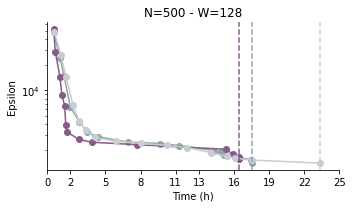

In [40]:
#Plot Epsilon development over time (Figure 20B & 22)
fig, axes = plt.subplots(1,1, figsize=(5,3))

ax = axes
ax.plot(ORIDF["time_passed_s"], ORIDF["epsilon"], label = "DYN", marker="o", color=samplers_color[0])
ax.plot(DLADF["time_passed_s"], DLADF["epsilon"], label = "LA Pre", marker="o", color=samplers_color[1])
ax.plot(LA_curr["time_passed_s"], LA_curr["epsilon"], label = "LA Cur", marker="o", color=samplers_color[2])

ax.set_yscale("log")
ax.set_ylabel("Epsilon")
ax.set_xlabel("Time (h)")
ax.axvline(ORIDF["time_passed_s"].iloc[-1], linestyle='dashed', color=samplers_color[0])
ax.axvline(DLADF["time_passed_s"].iloc[-1], linestyle='dashed', color=samplers_color[1])
ax.axvline(LA_curr["time_passed_s"].iloc[-1], linestyle='dashed', color=samplers_color[2])
ax.set_xlim(xmin=0)
xticklabels=[int(a/3600) for a in (ax.get_xticks())]
ax.set_xticks([a*3600 for a in xticklabels])
ax.set_xticklabels(xticklabels)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(f"N={str(psize)} - W={str(wsize)}")
# ax.legend()

fig.tight_layout()
plt.savefig(f"M2_figures/M2_EpsilonOverTimeN{str(psize)}W{str(wsize)}V{str(version)}.pdf")
